In [3]:
# Written by Dara Storer
# 03/10/20

%matplotlib inline
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from pyuvdata import UVData
from uvtools import dspec
import hera_qm 
import math

This notebook is analyzing data that was taken on site. We were testing the effects of whether dish doors are on/off, having extra mesh sitting inside the dish, and the extreme case of having the extra mesh grounded to the metal braid that comes down from the feed. See the README file in this folder for details on each test shown below. 

## Day 1 spectra - Thunderstorms

### Showing all tests:

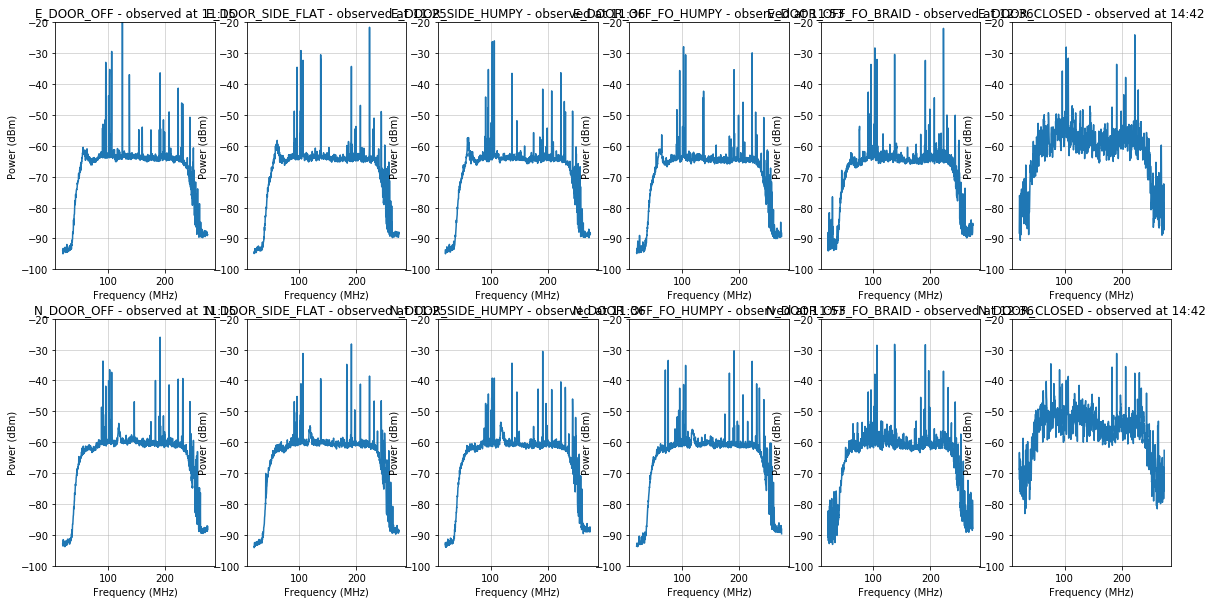

In [116]:
path = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458932/zen.2458932.59273.sum.uvh5'
tests = ['OFF','SIDE_FLAT','SIDE_HUMPY','OFF_FO_HUMPY','OFF_FO_BRAID','CLOSED']
times = ['11:15','11:25','11:36','11:53','12:36','14:42']
plot_spectra(tests=tests, times=times, Type='spectra', namePrefix='Day1_FreqSpectra_Thunder_AllTests', save=True)

### Showing only primary tests (tests that were repeated on Day 2)

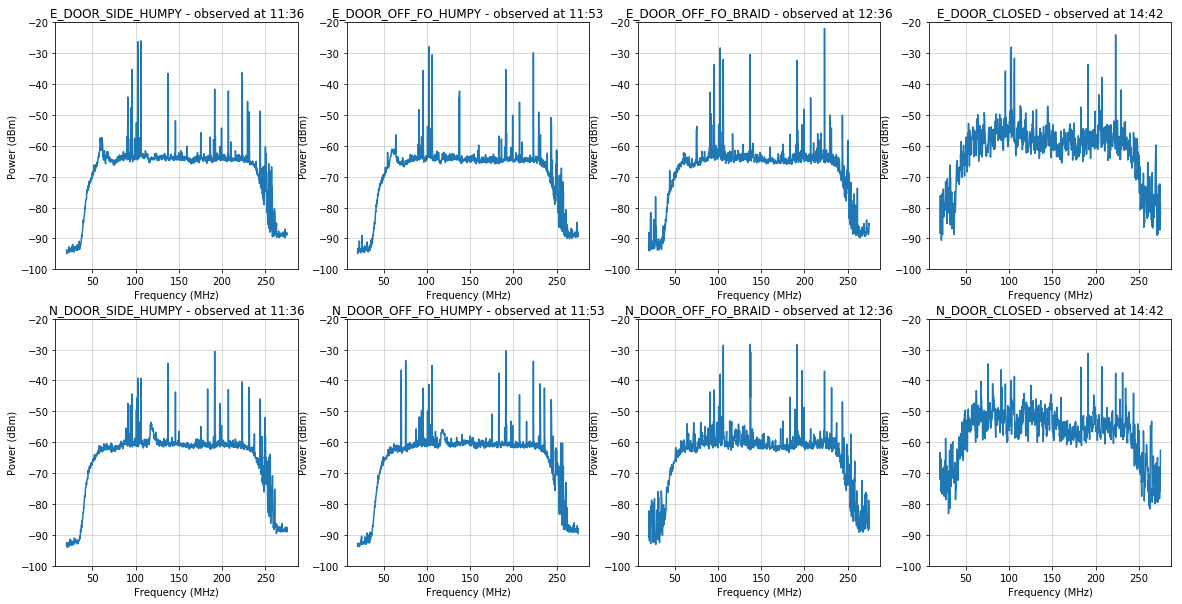

In [117]:
times = ['11:36','11:53','12:36','14:42']
tests = ['SIDE_HUMPY','OFF_FO_HUMPY','OFF_FO_BRAID','CLOSED']
plot_spectra(tests=tests, times=times, Type='spectra', namePrefix='Day1_FreqSpectra_Thunder_PrimaryTests', save=True)

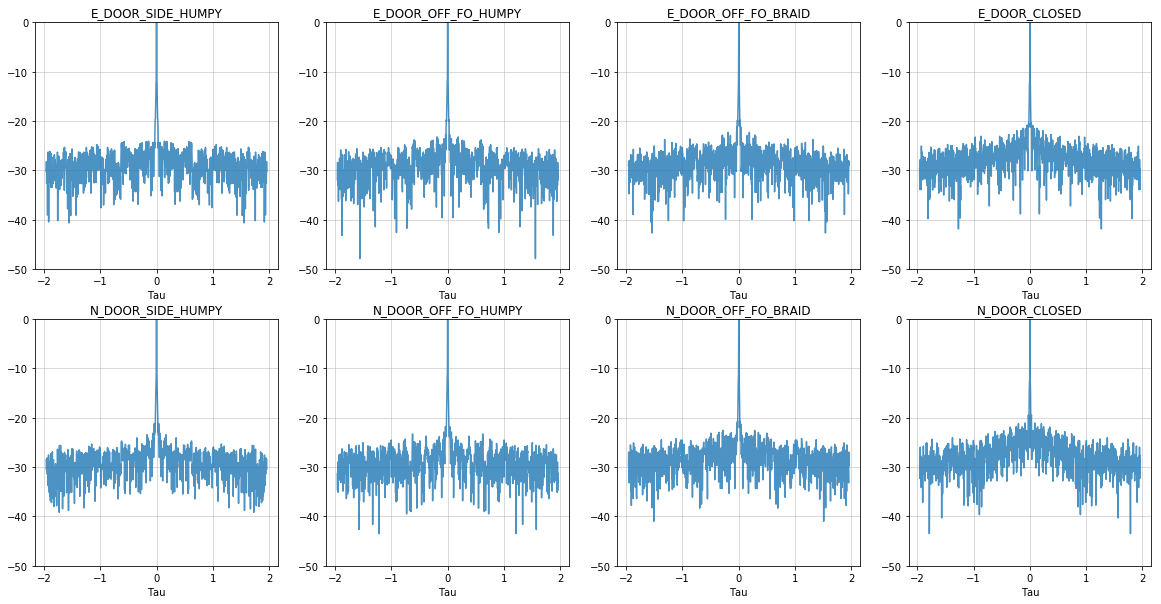

In [119]:
plot_spectra(tests=tests, Type='delay', namePrefix='Day1_DelaySpectra_full', save=True)

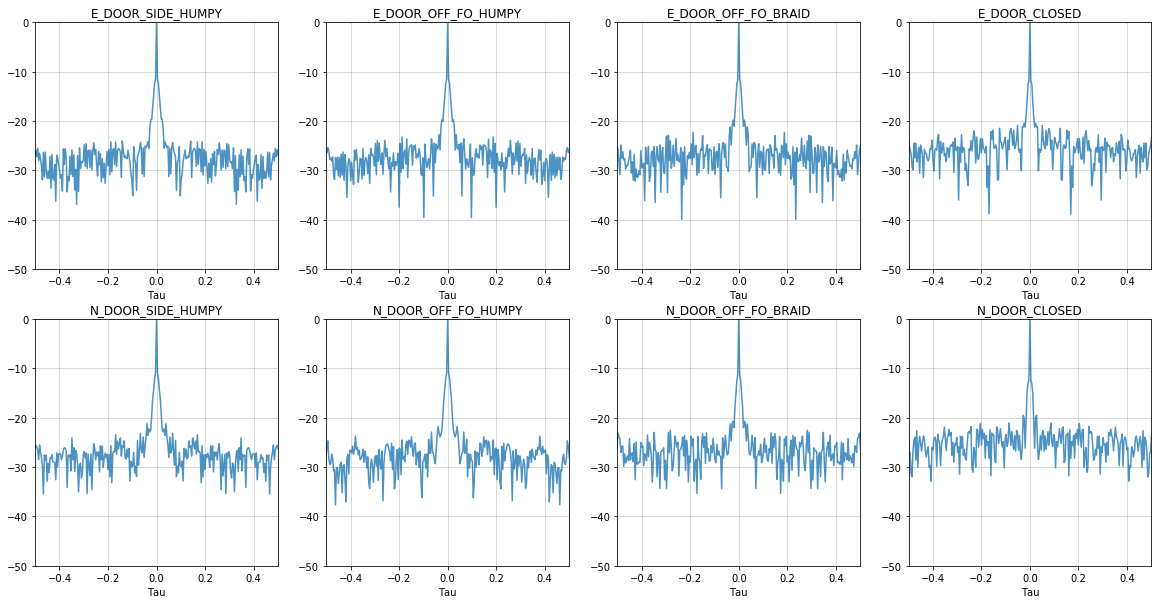

In [120]:
plot_spectra(tests=tests, Type='delay', namePrefix='Day1_DelaySpectra_clipped', save=True, clipDelay=True)

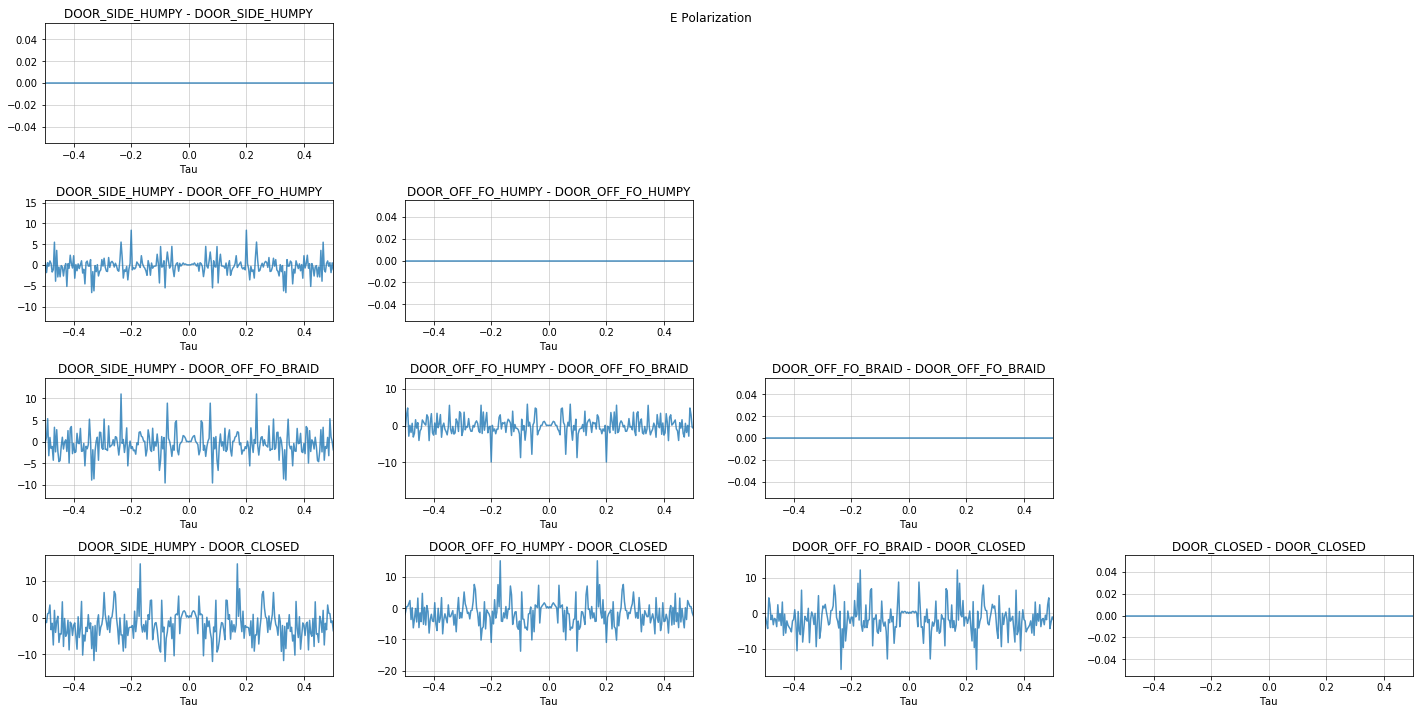

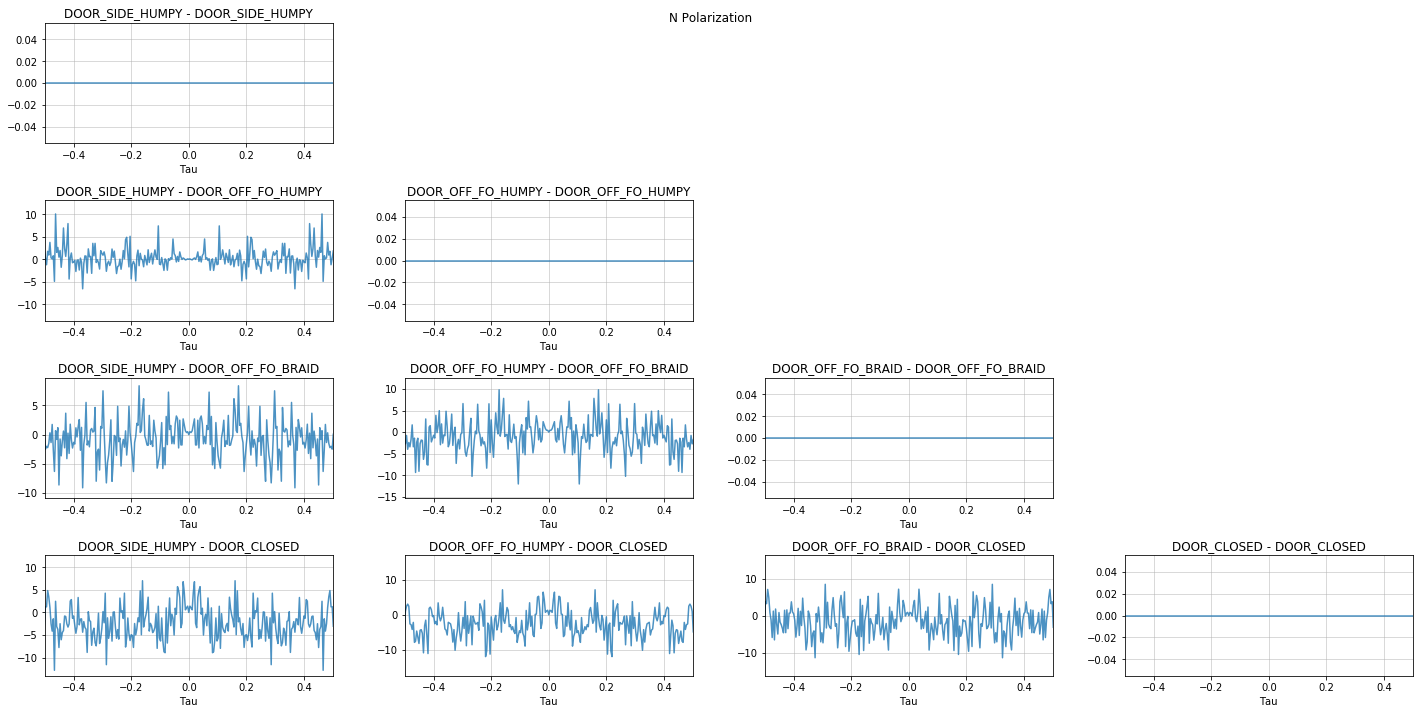

In [121]:
plot_differences(tests=tests, Type='delay', namePrefix='Day1_DelaySpectra_clipped_Diff', save=True, clipDelay=True)

## Day 2 Tests

### Spectra

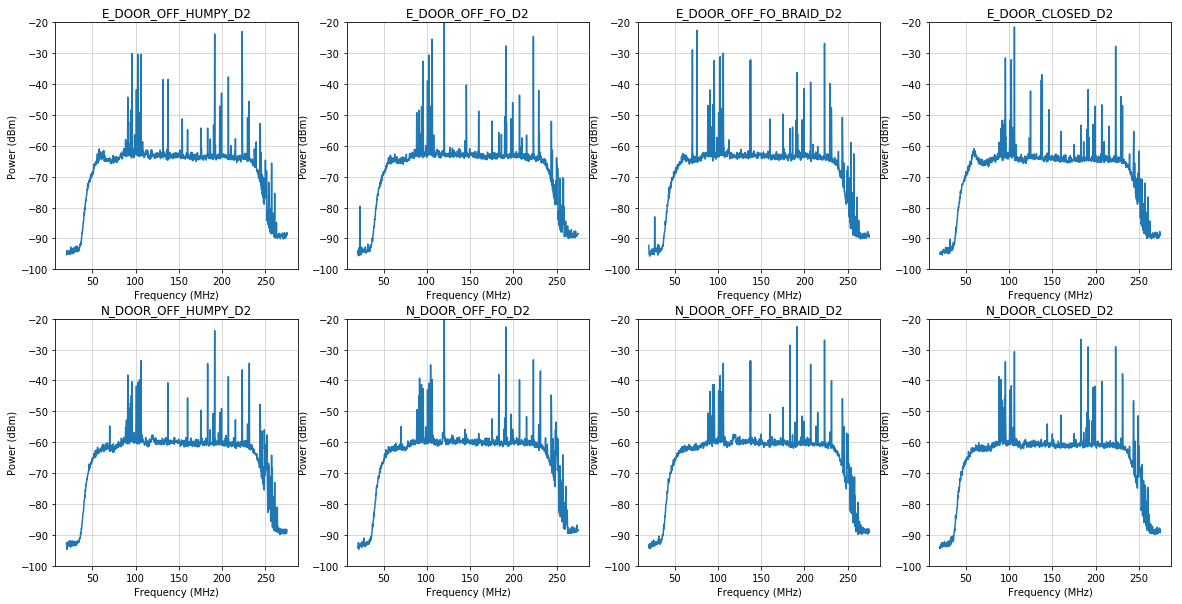

In [122]:
tests = ['OFF_HUMPY_D2','OFF_FO_D2','OFF_FO_BRAID_D2','CLOSED_D2']
plot_spectra(tests=tests, Type='spectra', namePrefix='Day2_FreqSpectra', save=True)

### Delay Spectra:

#### Showing all delays

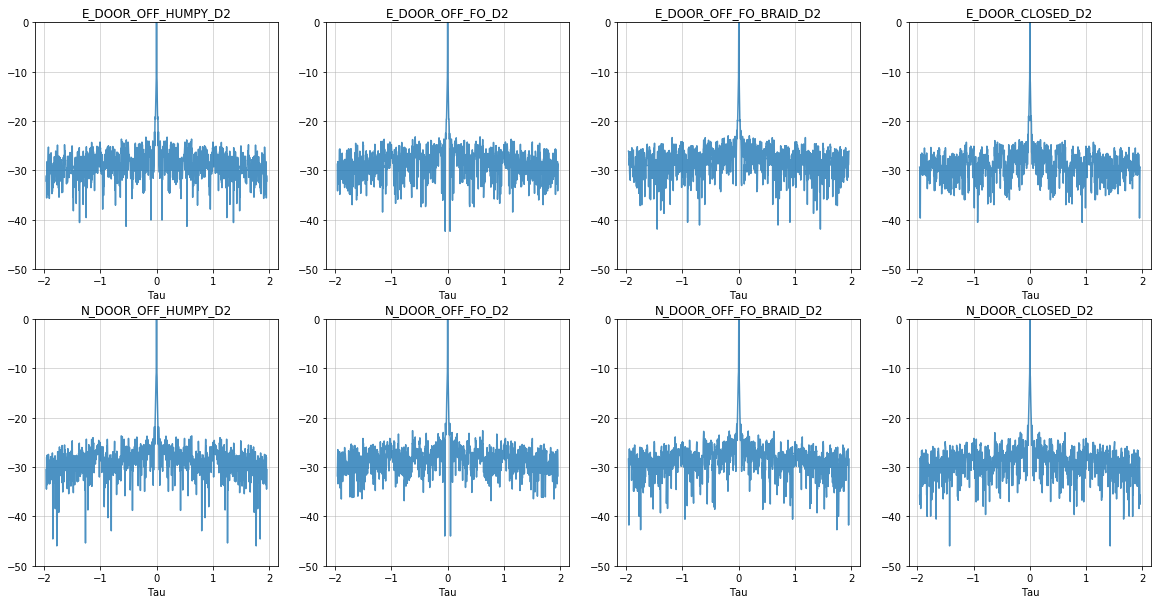

In [123]:
plot_spectra(tests=tests, Type='delay', namePrefix='Day2_DelaySpectra_full', save=True)

#### Clipping to zoom in on small delays

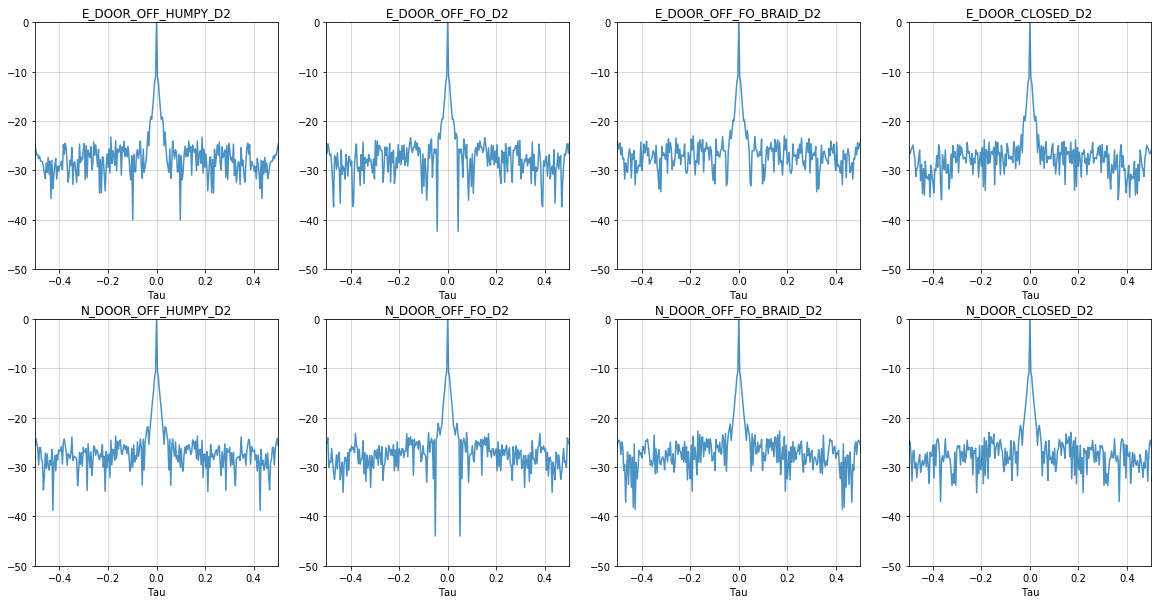

In [124]:
plot_spectra(tests=tests, Type='delay', namePrefix='Day2_DelaySpectra_clipped', save=True, clipDelay=True)

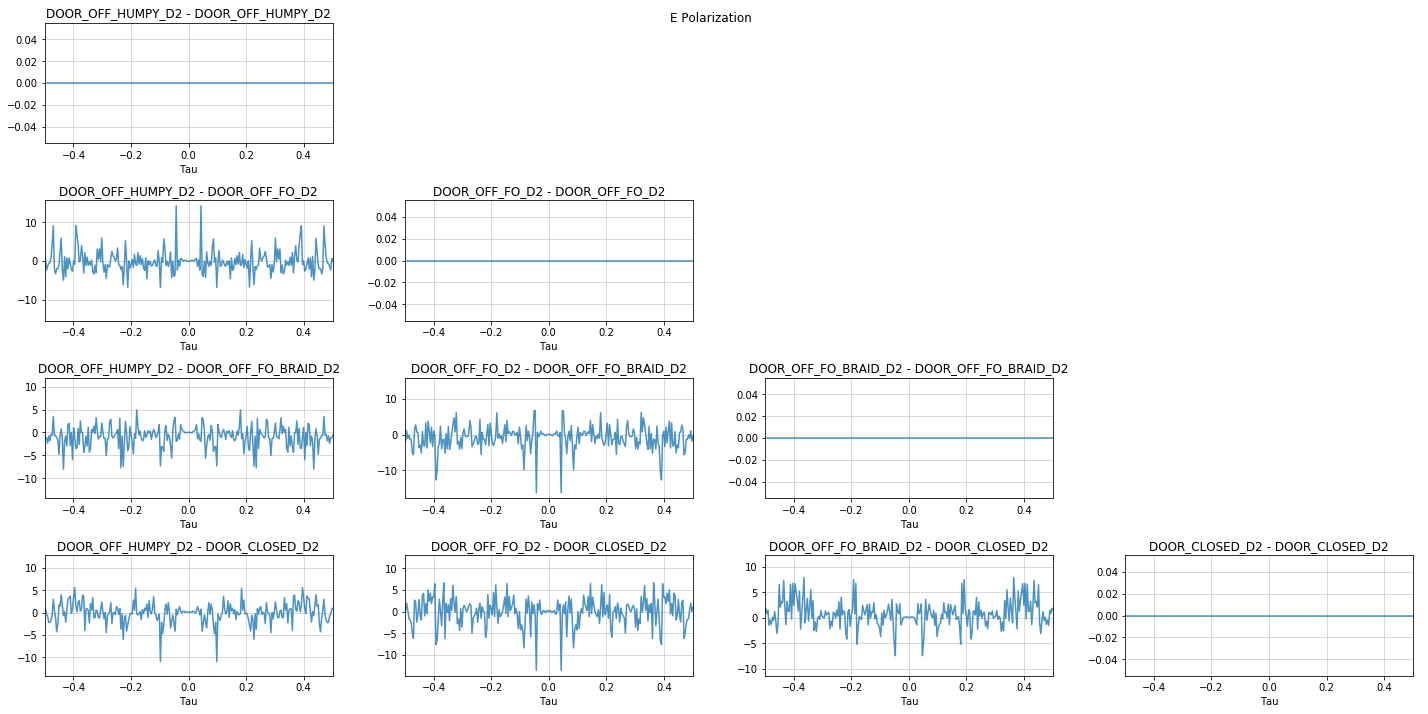

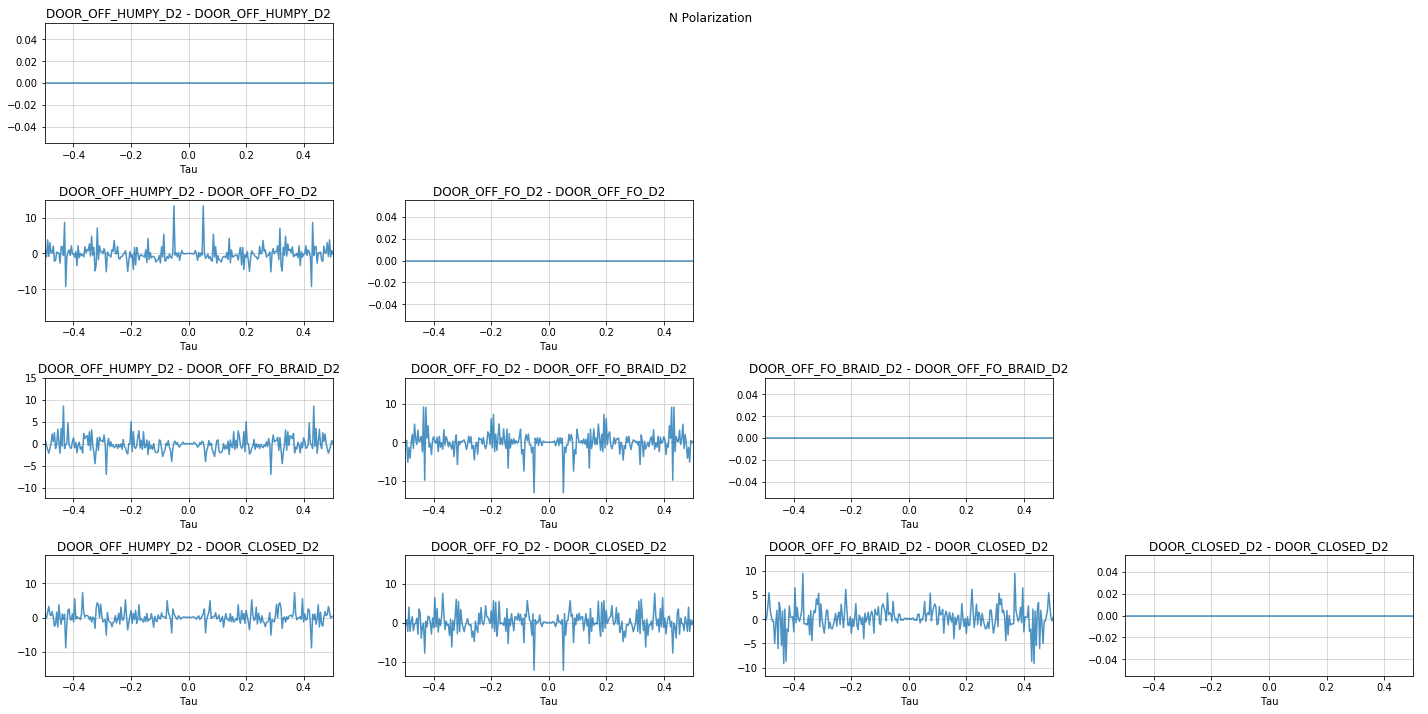

In [125]:
plot_differences(tests=tests, Type='delay', namePrefix='Day2_DelaySpectra_clipped_Diff', save=True, clipDelay=True)

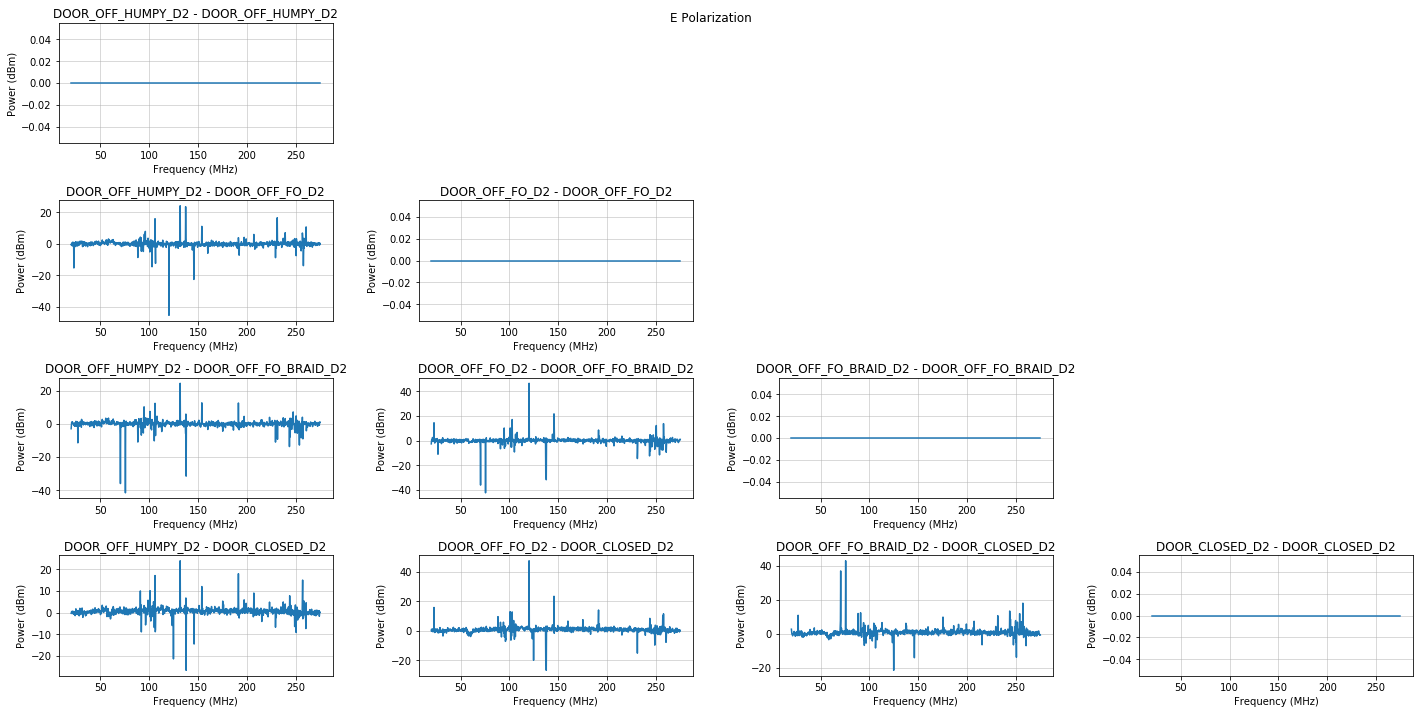

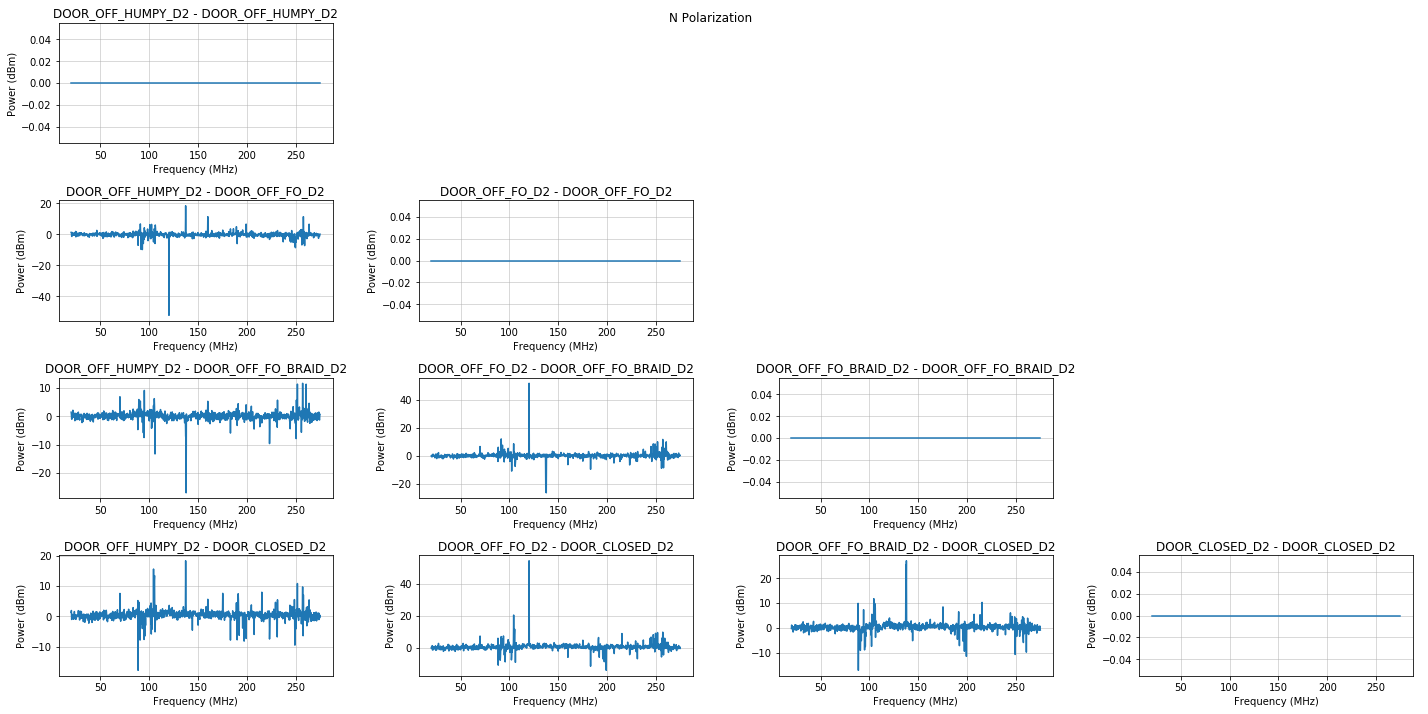

In [126]:
plot_differences(tests=tests, Type='spectra', namePrefix='Day2_RawSpectra_clipped_Diff', save=True, clipDelay=True)

In [3]:
def plot_differences(tests=['OPEN'], Type='spectra', pols=['E','N'], skip_header=16, broad=True,
             times=None, namePrefix='', save=False, clipDelay=False):
    ntests = len(tests)
    npols = len(pols)
    for p in range(len(pols)):
        fig, axs = plt.subplots(ntests,ntests,figsize=(20, 10))
        for t in range(len(tests)):
            for t2 in range(len(tests)):
                if t2 > t:
                    axs[t][t2].axis('off')
                    continue
                test1 = tests[t]
                test2 = tests[t2]
                pol = pols[p]
                name1 = '/A157%s_DOOR_%s' % (pol,test1)
                infile1 = path + name1 + '.csv'
                freq1, data1 = np.genfromtxt(
                    infile1, delimiter=',', skip_header=skip_header, skip_footer=1,
                    usecols=(0, 1), unpack=True
                )
                data1 = np.asarray(data1)
                autos1 = np.multiply(data1, np.conj(data1))
                freq = np.asarray(freq1 / 1e6)
                taus = np.fft.fftshift(np.fft.fftfreq(freq.size, np.diff(freq)[0]))
                delay1 = np.square(np.fft.fftshift(np.fft.fft(data1)))
                ds1 = 10.*np.log10(np.sqrt(np.abs(delay1)/np.abs(delay1).max(axis=0)))
                
                name2 = '/A157%s_DOOR_%s' % (pol,test2)
                infile2 = path + name2 + '.csv'
                freq2, data2 = np.genfromtxt(
                    infile2, delimiter=',', skip_header=skip_header, skip_footer=1,
                    usecols=(0, 1), unpack=True
                )
                data2 = np.asarray(data2)
                autos2 = np.multiply(data2, np.conj(data2))
                freq = np.asarray(freq2 / 1e6)
                taus = np.fft.fftshift(np.fft.fftfreq(freq.size, np.diff(freq)[0]))
                delay2 = np.square(np.fft.fftshift(np.fft.fft(data2)))
                ds2 = 10.*np.log10(np.sqrt(np.abs(delay2)/np.abs(delay2).max(axis=0)))
                if Type=='spectra':
                    dif = np.subtract(data2,data1)
                    axs[t][t2].plot(freq, dif)
                    axs[t][t2].set_xlabel('Frequency (MHz)')
                    axs[t][t2].set_ylabel('Power (dBm)')
                elif Type=='delay':
                    dif = np.subtract(ds2, ds1)
                    axs[t][t2].plot(taus, dif, alpha=0.8)
                    axs[t][t2].set_xlabel('Tau')
                    if clipDelay:
                        axs[t][t2].set_xlim((-.5,.5))
                else:
                    print('Invalid Type variable')
                    break
                axs[t][t2].grid(which='both')
                axs[t][t2].grid(which='minor', alpha=0.3)
                axs[t][t2].grid(which='major', alpha=0.6)
                axs[t][t2].set_title(name2[7:] + ' - ' + name1[7:])
        fig.suptitle(str(pol) + ' Polarization')
        fig.tight_layout(pad=1.0)
        if save:
            fig.savefig(path + '/' + namePrefix + '_' + str(pol) + '.pdf', format='pdf')

In [4]:
def plot_spectra(tests=[], Type='spectra', pols=['XX','YY'], namePrefix='', smPath='', dfPath='',
                 save=False, clipDelay=False, freqClip=None, flag=False, names=[], use_clean_ds=False,
                polDirs=['nn','ee'], scale='log', antenna_nums=[]):
    ntests = len(tests)
    npols = len(pols)
    fig, axs = plt.subplots(npols,ntests,figsize=(20, 10))
    uv = UVData()
    uv.read(smPath, antenna_nums=antenna_nums)
    for t in range(len(tests)):
        test = tests[t]
        for p in range(len(pols)):
            pol = pols[p]
            dat = uv.get_data((test[0],test[1],pol))
            freq = (np.asarray(uv.freq_array)[0])*10**(-6)
            data = np.copy(dat[0])
            if freqClip != None:
                ind0 = np.argmin(np.abs(freq-freqClip[0]))
                ind1 = np.argmin(np.abs(freq-freqClip[1]))
                freq = freq[ind0:ind1]
                data = data[ind0:ind1]
            autos = 10*np.log10(np.abs(data))
            if flag is True:
                m = np.median(autos)
                s = np.std(autos)
                for i in range(len(autos)):
                    d = autos[i]
                    if d > 60:
                    #if d > (m + 2*s):
                        #print('Flagging %s, pol %s at %fMHz' % (t, pol, freq[i]))
                        autos[i] = m
            if Type=='spectra':
                axs[p][t].plot(freq, autos)
                axs[p][t].set_xlabel('Frequency (MHz)')
                axs[p][t].set_ylabel('Power (dBm)')
                axs[p][t].set_ylim((30,80))
            elif Type=='delay':
                taus = np.fft.fftshift(np.fft.fftfreq(freq.size, np.diff(freq)[0]))
                if use_clean_ds==False:
                    delay = np.square(np.fft.fftshift(np.fft.fft(data)))
                else:
                    delay,_,_,_ = clean_ds(smPath, dfPath, [test], polarizations=pols, polDirs=polDirs)
                    delay = delay[(test[0],test[1],polDirs[p])][0]
                if scale == 'log':
                    ds = 10.*np.log10(np.sqrt(np.abs(delay)/np.abs(delay).max(axis=0)))
                    axs[p][t].set_ylim((-30,0))
                elif scale == 'linear':
                    ds = delay
                    #axs[0][t].set_ylim((0,1*10**8))
                    #axs[1][t].set_ylim((0,1*10**7))
                    #axs[2][t].set_ylim((0,1.5*10**6))
                    #axs[3][t].set_ylim((0,1.5*10**6))
                else:
                    print('Invalid scale keyword')
                    break
                axs[p][t].plot(taus, ds, alpha=0.8)
                axs[p][t].set_xlabel('Tau')
                if clipDelay:
                    axs[p][t].set_xlim((-1,1))
                #axs[p][t].set_ylim((-50,0))
            else:
                print('Invalid Type variable')
                break
            axs[p][t].grid(which='both')
            axs[p][t].grid(which='minor', alpha=0.3)
            axs[p][t].grid(which='major', alpha=0.6)
            axs[p][t].set_title('%s - %s pol' % (str(test), polDirs[p]))
        #axs[t].suptitle(names[t])
    if scale == 'log':
        for p in range(len(pols)):
            axs[p][0].set_ylabel(r'$|\tilde{V}(\tau)|$ (dB)')
    fig.tight_layout(pad=1.0)
    fig.suptitle('Both closed                                                                                                1 open, 1 closed                                                                                                      Both open', y=1.03)
    if save:
        fig.savefig(path + '/' + namePrefix + '.pdf', format='pdf')

In [5]:
def plot_spectra_singlePol(tests=[], Type='spectra', pol='XX', namePrefix='', smPath='', dfPath='',
                 save=False, clipDelay=False, freqClip=None, flag=False, names=[], use_clean_ds=False, scale='log', 
                           antenna_nums=[], polDirs=['nn'], openDoors=[]):
    ntests = len(tests)
    nside = int(np.ceil(np.sqrt(ntests)))
    print(nside)
    fig, axs = plt.subplots(nside,nside,figsize=(20, 10))
    uv = UVData()
    uv.read(smPath, antenna_nums=antenna_nums)
    for t in range(len(tests)):
        test = tests[t]
        y = int(np.floor(np.divide(t,nside)))
        if t < nside:
            x = t
        else:
            x = np.mod(t, nside)
        x = int(x)
        dat = uv.get_data((test[0],test[1],pol))
        freq = (np.asarray(uv.freq_array)[0])*10**(-6)
        data = np.copy(dat[0])
        if freqClip != None:
            ind0 = np.argmin(np.abs(freq-freqClip[0]))
            ind1 = np.argmin(np.abs(freq-freqClip[1]))
            freq = freq[ind0:ind1]
            data = data[ind0:ind1]
        autos = 10*np.log10(np.abs(data))
        if flag is True:
            m = np.median(autos)
            s = np.std(autos)
            for i in range(len(autos)):
                d = autos[i]
                if d > 60:
                #if d > (m + 2*s):
                    #print('Flagging %s, pol %s at %fMHz' % (t, pol, freq[i]))
                    autos[i] = m
        if Type=='spectra':
            axs[y][x].plot(freq, autos)
            axs[y][x].set_xlabel('Frequency (MHz)')
            axs[y][x].set_ylabel('Power (dBm)')
            axs[y][x].set_ylim((30,80))
        elif Type=='delay':
            taus = np.fft.fftshift(np.fft.fftfreq(freq.size, np.diff(freq)[0]))
            if use_clean_ds==False:
                delay = np.square(np.fft.fftshift(np.fft.fft(data)))
            else:
                delay,_,_,_ = clean_ds(smPath, dfPath, [test], polarizations=[pol], polDirs=polDirs)
                delay = delay[(test[0],test[1],pol)][0]
            if scale == 'log':
                ds = 10.*np.log10(np.sqrt(np.abs(delay)/np.abs(delay).max(axis=0)))
                axs[y][x].set_ylim((-30,0))
            elif scale == 'linear':
                ds = delay
                #axs[0][t].set_ylim((0,1*10**8))
                #axs[1][t].set_ylim((0,1*10**7))
                #axs[2][t].set_ylim((0,1.5*10**6))
                #axs[3][t].set_ylim((0,1.5*10**6))
            else:
                print('Invalid scale keyword')
                break
            axs[y][x].plot(taus, ds, alpha=0.8)
            axs[y][x].set_xlabel('Tau')
            if clipDelay:
                axs[y][x].set_xlim((-1,1))
            #axs[p][t].set_ylim((-50,0))
        else:
            print('Invalid Type variable')
            break
        title_obj = axs[y][x].set_title(str(test))
        axs[y][x].grid(which='both')
        axs[y][x].grid(which='minor', alpha=0.3)
        axs[y][x].grid(which='major', alpha=0.6)
        #axs[p][t].set_title('%s - %s pol' % (str(test), polDirs[p]))
        #axs[t].suptitle(names[t])
        if test[0] in openDoors and test[1] in openDoors:
            plt.setp(title_obj, color='r')
        elif test[0] in openDoors or test[1] in openDoors:
            plt.setp(title_obj, color='b')
        else:
            plt.setp(title_obj, color='g')
    if scale == 'log':
        for p in range(nside):
            axs[p][0].set_ylabel(r'$|\tilde{V}(\tau)|$ (dB)')
    fig.tight_layout(pad=1.0)
    if save:
        fig.savefig(path + '/' + namePrefix + '.pdf', format='pdf')

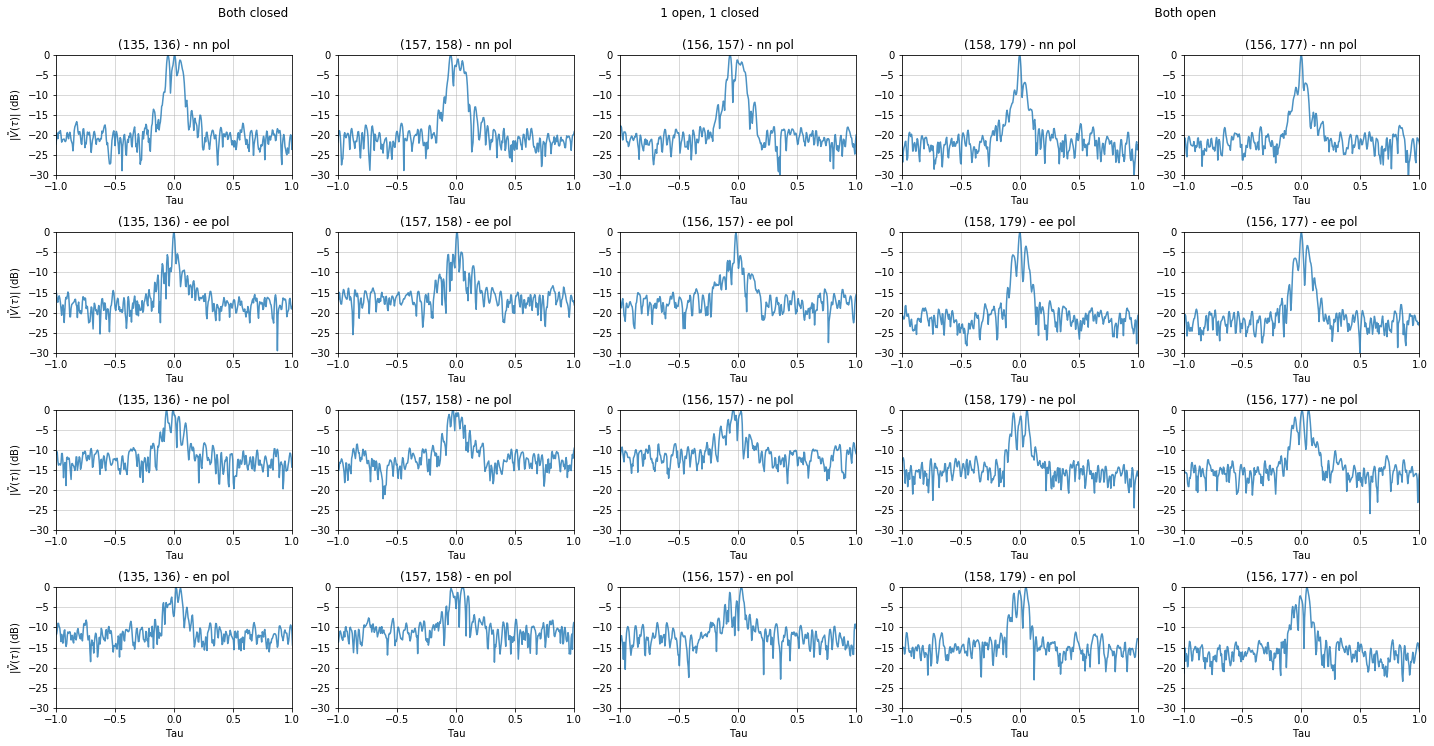

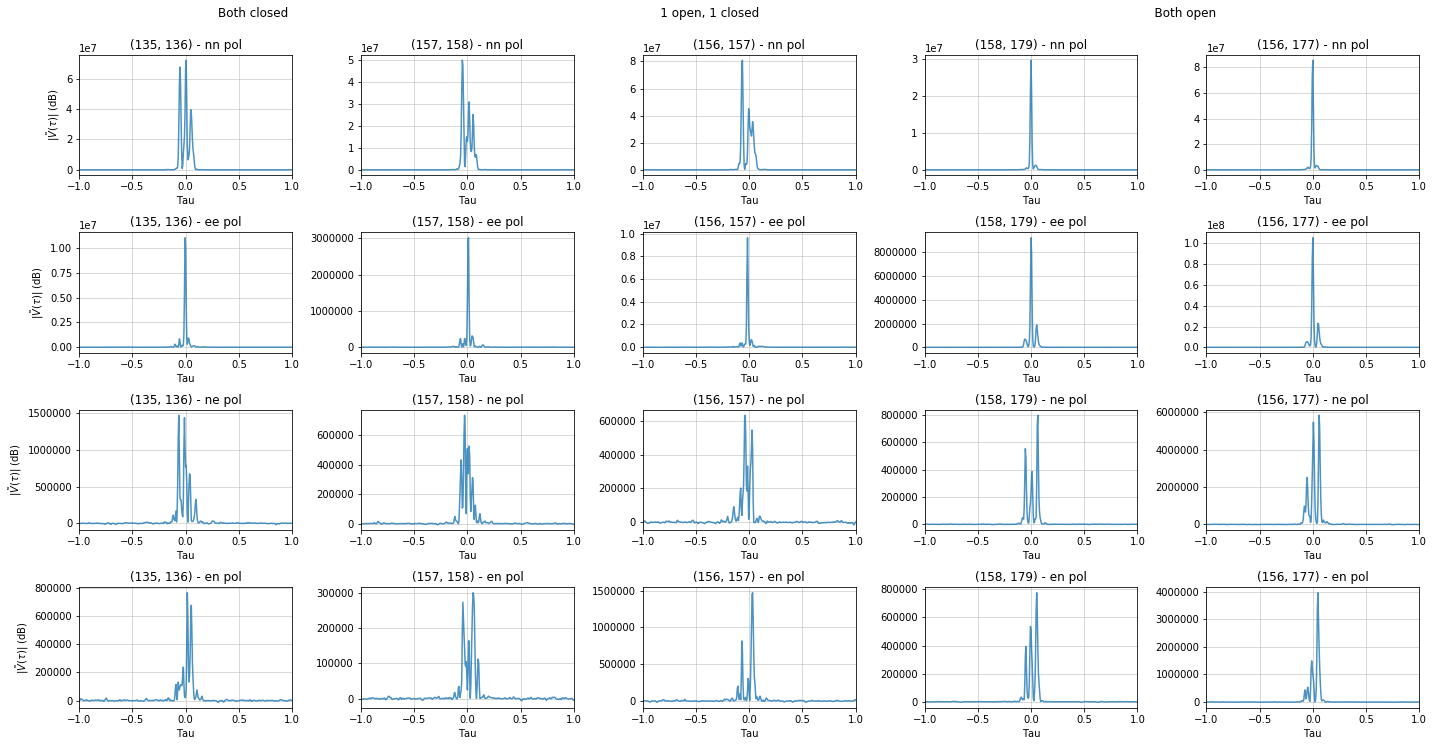

In [165]:
smPath = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458932/zen.2458932.59273.sum.uvh5'
dfPath = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458932/zen.2458932.59273.diff.uvh5'
#tests = [(135,136),(158,179),(157,158),(156,177),(156,157)]
tests = [(135,136),(157,158),(156,157),(158,179),(156,177)]
antenna_nums = [135,136,156,157,158,177,179]
testNames = ['Both Closed', '1 open, 1 closed', 'Both Open']
plot_spectra(tests=tests, Type='delay', namePrefix='Day2_FreqSpectra', save=False, names=testNames, flag=True,
            smPath=smPath, dfPath=dfPath, use_clean_ds=True, clipDelay=True, pols=['XX','YY','XY','YX'],
            polDirs=['nn','ee','ne','en'], scale='log', antenna_nums=antenna_nums )
plot_spectra(tests=tests, Type='delay', namePrefix='Day2_FreqSpectra', save=False, names=testNames, flag=True,
            smPath=smPath, dfPath=dfPath, use_clean_ds=True, clipDelay=True, pols=['XX','YY','XY','YX'],
            polDirs=['nn','ee','ne','en'], scale='linear', antenna_nums=antenna_nums)
#plot_spectra(tests=tests, Type='delay', namePrefix='Day2_FreqSpectra', save=False, names=testNames, flag=True,
#            smPath=smPath, dfPath=dfPath, use_clean_ds=False, clipDelay=True)

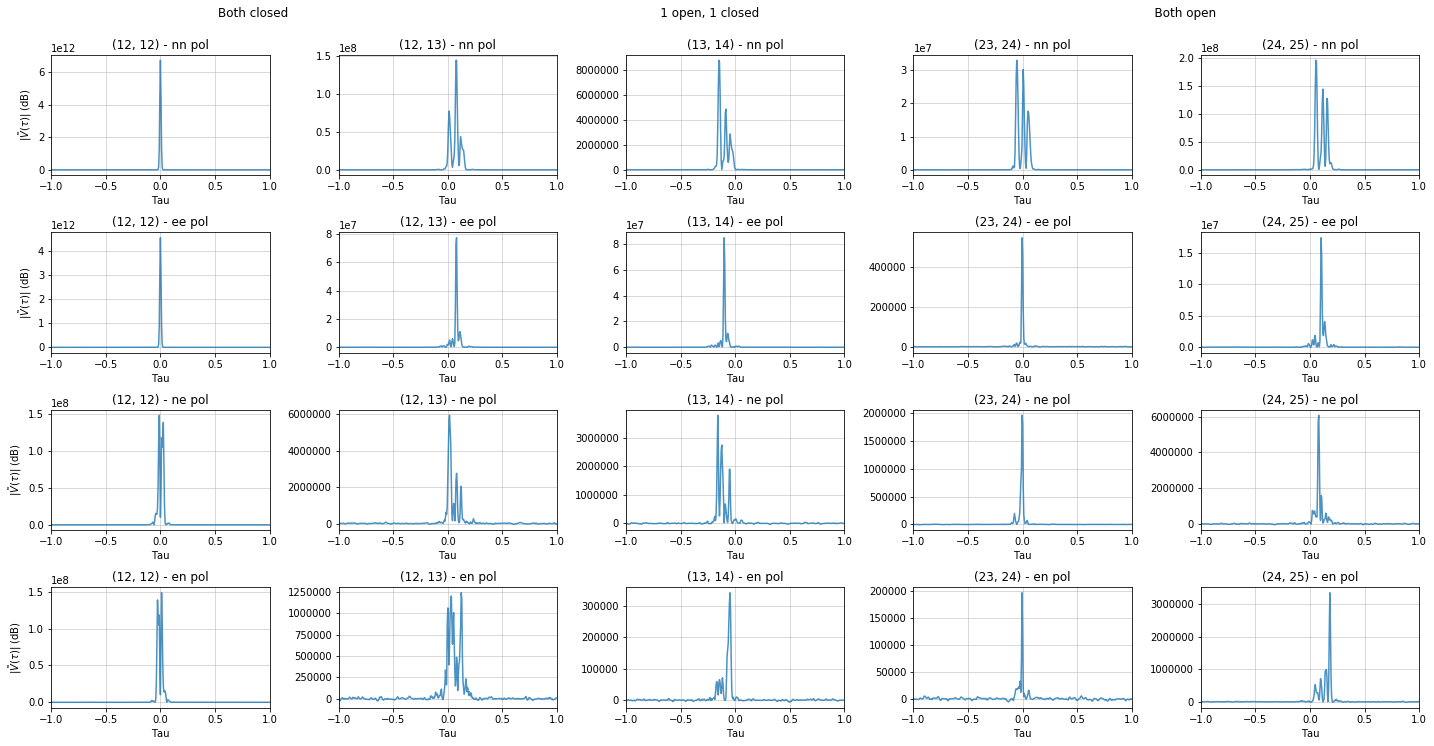

In [176]:
smPath = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458932/zen.2458932.59273.sum.uvh5'
dfPath = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458932/zen.2458932.59273.diff.uvh5'
#tests = [(135,136),(158,179),(157,158),(156,177),(156,157)]
tests = [(12, 12),(12, 13), (13, 14), (23, 24), (24, 25)]
antenna_nums = [12, 13, 14, 23, 24, 25]
testNames = ['Both Closed', '1 open, 1 closed', 'Both Open']
#plot_spectra(tests=tests, Type='delay', namePrefix='Day2_FreqSpectra', save=False, names=testNames, flag=True,
#            smPath=smPath, dfPath=dfPath, use_clean_ds=True, clipDelay=True, pols=['XX','YY','XY','YX'],
#            polDirs=['nn','ee','ne','en'], scale='log', antenna_nums=antenna_nums )
plot_spectra(tests=tests, Type='delay', namePrefix='Day2_FreqSpectra', save=False, names=testNames, flag=True,
            smPath=smPath, dfPath=dfPath, use_clean_ds=True, clipDelay=True, pols=['XX','YY','XY','YX'],
            polDirs=['nn','ee','ne','en'], scale='linear', antenna_nums=antenna_nums)

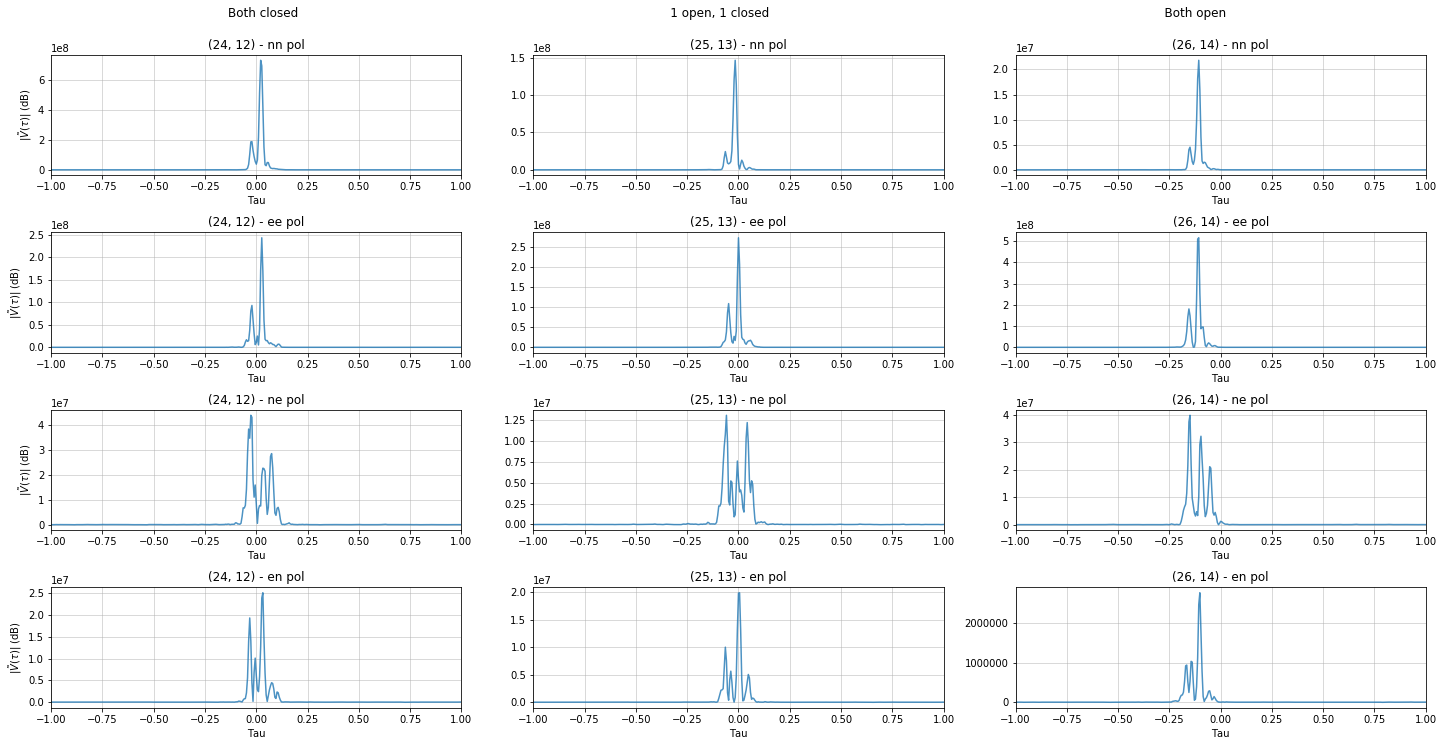

In [177]:
smPath = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458932/zen.2458932.59273.sum.uvh5'
dfPath = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458932/zen.2458932.59273.diff.uvh5'
#tests = [(135,136),(158,179),(157,158),(156,177),(156,157)]
tests = [(24,12), (25,13), (26,14)]
antenna_nums = [12, 13, 14, 24, 25, 26]
testNames = ['Both Closed', '1 open, 1 closed', 'Both Open']
#plot_spectra(tests=tests, Type='delay', namePrefix='Day2_FreqSpectra', save=False, names=testNames, flag=True,
#            smPath=smPath, dfPath=dfPath, use_clean_ds=True, clipDelay=True, pols=['XX','YY','XY','YX'],
#            polDirs=['nn','ee','ne','en'], scale='log', antenna_nums=antenna_nums )
plot_spectra(tests=tests, Type='delay', namePrefix='Day2_FreqSpectra', save=False, names=testNames, flag=True,
            smPath=smPath, dfPath=dfPath, use_clean_ds=True, clipDelay=True, pols=['XX','YY','XY','YX'],
            polDirs=['nn','ee','ne','en'], scale='linear', antenna_nums=antenna_nums)

[ 85  86  87  98  99 100 103 104 105 106 117 118 119 135 136 156 157 158
 176 177 178 179]
4


K1 value 8 is larger than the data of dimension 2; using the size of the data for the kernel size
Casting complex values to real discards the imaginary part


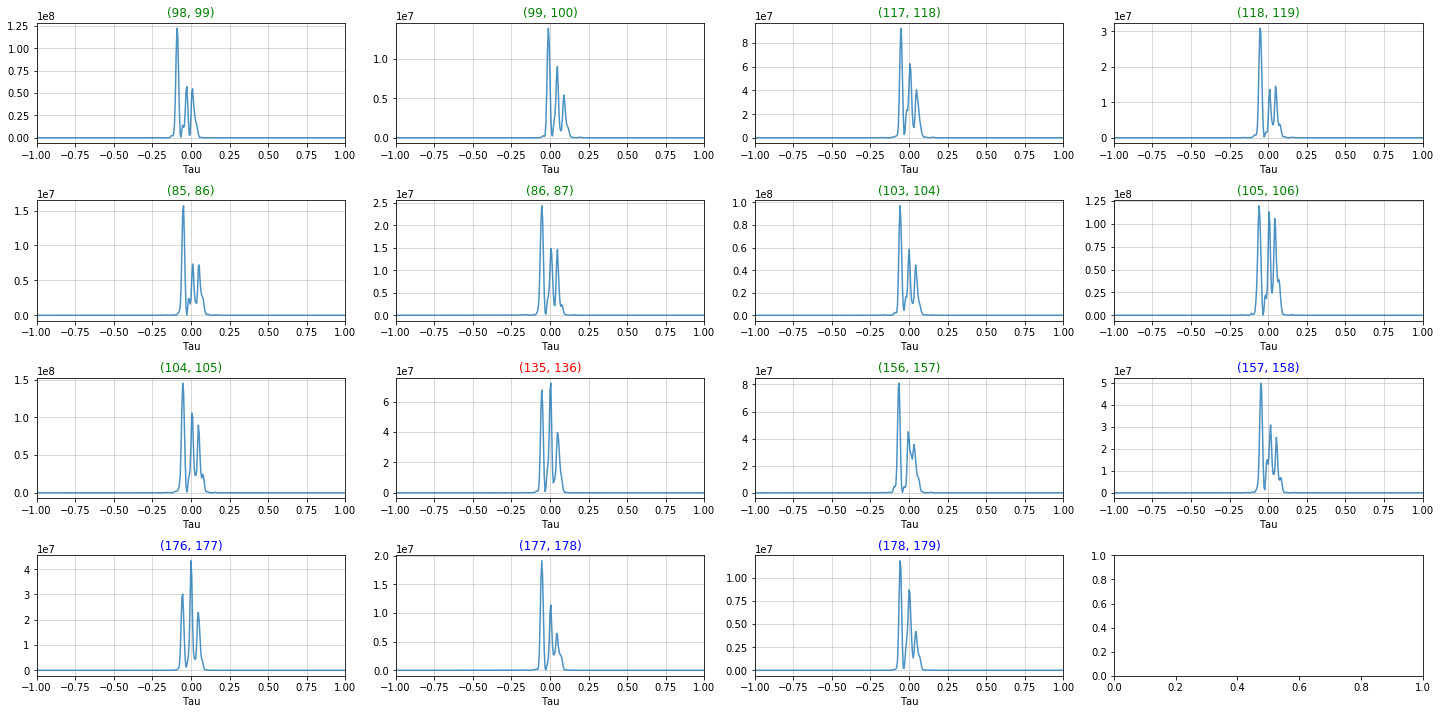

In [226]:
smPath = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458932/zen.2458932.59273.sum.uvh5'
dfPath = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458932/zen.2458932.59273.diff.uvh5'
tests = [(98,99),(99,100),(117,118),(118,119),(85,86),(86,87),(103,104),(105,106),(104,105),(135,136),(156,157),(157,158),
        (176,177),(177,178),(178,179)]
openDoors = [135,136,155,158,177,179]
antenna_nums = np.unique([pair[i] for i in range(2) for pair in tests])
print(antenna_nums)
plot_spectra_singlePol(tests=tests, Type='delay', namePrefix='Day2_FreqSpectra', save=False, names=testNames, flag=False,
            smPath=smPath, dfPath=dfPath, use_clean_ds=True, clipDelay=True, pol='XX', scale='linear', antenna_nums=antenna_nums,
                      openDoors=openDoors)

[ 85  86  87  98  99 100 103 104 105 106 117 118 119 135 136 156 157 158
 176 177 178 179]
4


KeyError: 'Polarization nn not found in data.'

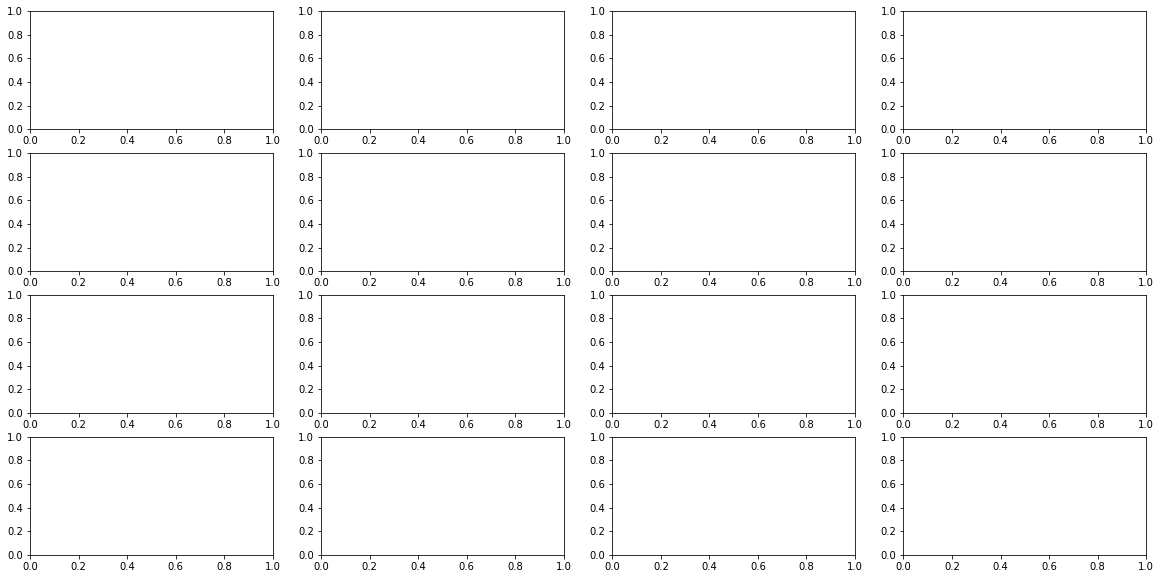

In [214]:
smPath = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458932/zen.2458932.59273.sum.uvh5'
dfPath = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458932/zen.2458932.59273.diff.uvh5'
tests = [(98,99),(99,100),(117,118),(118,119),(85,86),(86,87),(103,104),(105,106),(104,105),(135,136),(156,157),(157,158),
        (176,177),(177,178),(178,179)]
openDoors = [135,136,155,158,177,179]
antenna_nums = np.unique([pair[i] for i in range(2) for pair in tests])
print(antenna_nums)
plot_spectra_singlePol(tests=tests, Type='delay', namePrefix='Day2_FreqSpectra', save=False, names=testNames, flag=True,
            smPath=smPath, dfPath=dfPath, use_clean_ds=True, clipDelay=True, pol='YY', scale='linear', antenna_nums=antenna_nums,
                      openDoors=openDoors)

[ 98  99 100 103 104 117 118 119 135 136 156 157 158]
3


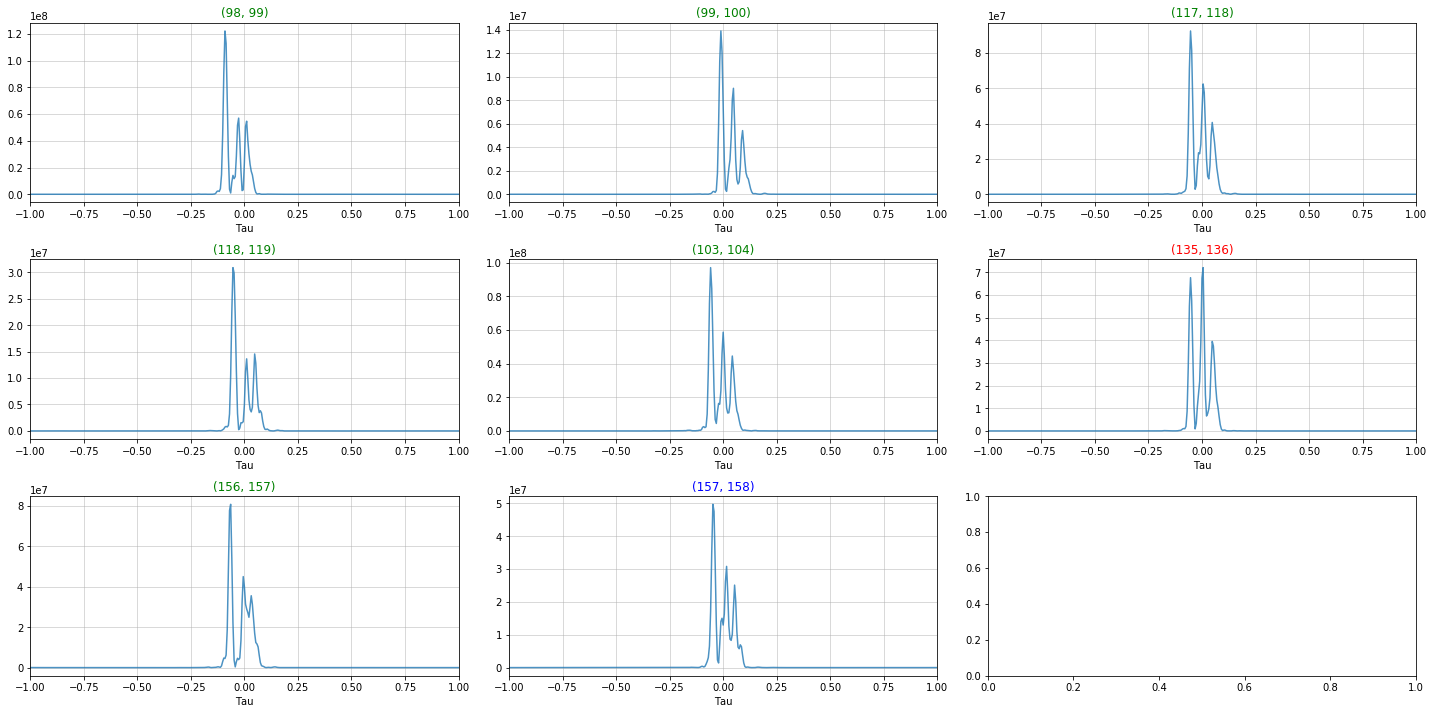

In [234]:
smPath = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458932/zen.2458932.59273.sum.uvh5'
dfPath = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458932/zen.2458932.59273.diff.uvh5'
tests = [(98,99),(99,100),(117,118),(118,119),(85,86),(86,87),(103,104),(105,106),(104,105),(135,136),(156,157),(157,158),
        (176,177),(177,178),(178,179)]
tests = [(98,99),(99,100),(117,118),(118,119),(103,104),(135,136),(156,157),(157,158)]
openDoors = [135,136,155,158,177,179]
antenna_nums = np.unique([pair[i] for i in range(2) for pair in tests])
print(antenna_nums)
plot_spectra_singlePol(tests=tests, Type='delay', namePrefix='Day2_FreqSpectra', save=False, names=testNames, flag=True,
            smPath=smPath, dfPath=dfPath, use_clean_ds=True, clipDelay=True, pol='XX', scale='linear', antenna_nums=antenna_nums,
                      openDoors=openDoors)

In [11]:
def clean_ds(sm, df, bls, area=1000., tol=1e-9, skip_wgts=0.2, polarizations=['XX','YY'], polDirs=['nn','ee']): 
    
    uvd_ds = UVData()
    uvd_ds.read(sm, bls=bls, polarizations=polarizations, keep_all_metadata=False)
    uvd_diff = UVData()
    uvd_diff.read(df, bls=bls, polarizations=polarizations, keep_all_metadata=False)
    times = np.unique(uvd_ds.time_array)
    Nfiles = 1
    
    uvf_m, uvf_fws = hera_qm.xrfi.xrfi_h1c_pipe(uvd_ds, sig_adj=1, sig_init=3)
    hera_qm.xrfi.flag_apply(uvf_m, uvd_ds)
    
    freqs = uvd_ds.freq_array[0]
    FM_idx = np.searchsorted(freqs*1e-6, [85,110])
    flag_FM = np.zeros(freqs.size, dtype=bool)
    flag_FM[FM_idx[0]:FM_idx[1]] = True
    win = dspec.gen_window('bh7', freqs.size)
    
    _data_sq_cleaned, data_rs = {}, {}
    for bl in bls:
        for i, pol in enumerate(polarizations):
            key = (bl[0],bl[1],pol)
            data = uvd_ds.get_data(key)
            diff = uvd_diff.get_data(key)
            wgts = (~uvd_ds.get_flags(key)*~flag_FM[np.newaxis,:]).astype(float)

            d_even = (data+diff)*0.5
            d_odd = (data-diff)*0.5
            d_even_cl, d_even_rs, _ = dspec.high_pass_fourier_filter(d_even, wgts, area*1e-9, freqs[1]-freqs[0], 
                                                                     tol=tol, skip_wgt=skip_wgts, window='bh7')
            d_odd_cl, d_odd_rs, _ = dspec.high_pass_fourier_filter(d_odd, wgts, area*1e-9, freqs[1]-freqs[0],
                                                                   tol=tol, skip_wgt=skip_wgts, window='bh7')

            idx = np.where(np.mean(np.abs(d_even_cl), axis=1) == 0)[0]
            d_even_cl[idx] = np.nan
            d_even_rs[idx] = np.nan        
            idx = np.where(np.mean(np.abs(d_odd_cl), axis=1) == 0)[0]
            d_odd_cl[idx] = np.nan
            d_odd_rs[idx] = np.nan

            _d_even = np.fft.fftshift(np.fft.ifft((d_even_cl+d_even_rs)*win), axes=1)
            _d_odd = np.fft.fftshift(np.fft.ifft((d_odd_cl+d_odd_rs)*win), axes=1)

            _data_sq_cleaned[key] = _d_odd.conj()*_d_even
            data_rs[key] = d_even_rs
        
    return _data_sq_cleaned, data_rs, uvd_ds, uvd_diff

In [12]:
def get_delays(tests=[], smPath='', pol='XX', namePrefix='', dfPath='',
                 save=False, clipDelay=False, freqClip=None, flag=False, names=[], use_clean_ds=True, scale='log', 
                           antenna_nums=[], polDirs=['nn'], openDoors=[], testType='cross'):
    ntests = len(tests)
    nside = int(np.ceil(np.sqrt(ntests)))
    uv = UVData()
    if len(antenna_nums) == 0:
        #uv.read(smPath, polarizations=[pol])
        uv.read(smPath)
    else:
        uv.read(smPath, antenna_nums=antenna_nums)
    delays = {}
    for t in range(len(tests)):
        if testType == 'autos':
            test = (tests[t],tests[t])
        elif testType == 'baselines':
            test = uv.baseline_to_antnums(tests[t])
        else:
            test = tests[t]
        y = int(np.floor(np.divide(t,nside)))
        if t < nside:
            x = t
        else:
            x = np.mod(t, nside)
        x = int(x)
        dat = uv.get_data((test[0],test[1],pol))
        freq = (np.asarray(uv.freq_array)[0])*10**(-6)
        data = np.copy(dat[0])
        if freqClip != None:
            ind0 = np.argmin(np.abs(freq-freqClip[0]))
            ind1 = np.argmin(np.abs(freq-freqClip[1]))
            freq = freq[ind0:ind1]
            data = data[ind0:ind1]
        autos = 10*np.log10(np.abs(data))

        taus = np.fft.fftshift(np.fft.fftfreq(freq.size, np.diff(freq)[0]))
        if use_clean_ds==False:
            delay = np.square(np.fft.fftshift(np.fft.fft(data)))
        else:
            delay,_,_,_ = clean_ds(smPath, dfPath, [test], polarizations=[pol], polDirs=polDirs)
            delay = delay[(test[0],test[1],pol)][0]
        if scale == 'log':
            ds = 10.*np.log10(np.sqrt(np.abs(delay)/np.abs(delay).max(axis=0)))
        elif scale == 'linear':
            ds = delay
        else:
            print('Invalid scale keyword')
            break
        
        if clipDelay == True:
            l = len(ds)
            ds = ds[l//3:-l//3]
        delays[test] = ds
    return delays

In [130]:
def get_delayRedundancyMeasure(smPath,dfPath,pols=['xx','yy','xy','yx'], nThresh=1, printInds=True, scale='linear',
                              clipDelay=True):
    uv = UVData()
    uv.read(smPath)
    baseline_groups,vec_bin_centers,lengths = uv.get_redundancies(use_antpos=True,include_autos=False)
    ant_red_zscores = {}
    print('Total number of baseline groups is: %i' % len(baseline_groups))
    for ant in uv.antenna_numbers:
        ant_red_zscores[ant] = {}
        ant_red_zscores[ant]['x'] = []
        ant_red_zscores[ant]['y'] = []
    for pol in pols:
        print('Calculating for polarization: %s' % pol)
        for i in range(len(baseline_groups)):
            if len(baseline_groups[i]) < nThresh:
                continue
            else:
                if printInds == True:
                    print('%i - %i baselines' % (i,len(baseline_groups[i])))
            delays = get_delays(baseline_groups[i],smPath=smPath, dfPath=dfPath, testType='baselines', pol=pol, 
                                scale=scale, clipDelay=clipDelay)
            base_vis = []
            base_ds = np.zeros((512,len(baseline_groups[i])))
            for n,j in enumerate(baseline_groups[i]):
                ants = uv.baseline_to_antnums(j)
                ds = delays[ants]
                base_ds[:,n] = ds
            for n,j in enumerate(baseline_groups[i]):
                ants = uv.baseline_to_antnums(j)
                med_ds = np.nanmedian(np.abs(base_ds),1)
                medAbsDev = np.nanmedian(np.transpose(np.abs(np.transpose(np.abs(base_ds)) - med_ds)),1)
                z = 0.6745 * np.divide(np.abs((np.abs(delays[ants]) - med_ds)),medAbsDev)
                ant_red_zscores[ants[0]][pol[0]].append(np.median(z))
                ant_red_zscores[ants[1]][pol[1]].append(np.median(z))
    return ant_red_zscores

def plotBubbles_delayRedundancy(smPath,dfPath,marker='bo',alpha=0.5, pols=['xx','yy','xy','yx'], zscores=None):
    uv = UVData()
    uv.read(smPath)
    antpols = ['x','y']
    poldirs = ['N-S','E-W']
    fig, axs = plt.subplots(2,1, figsize=(10,12))
    if zscores == None:
        print('Calculating z-scores....')
        ant_red_zscores = get_delayRedundancyMeasure(smPath, dfPath, pols)
    else:
        ant_red_zscores = zscores
    for j in range(len(antpols)):
        for i in range(len(uv.antenna_positions)):
            antpos = uv.antenna_positions[i]
            antnum = uv.antenna_numbers[i]
            meanz = np.nanmedian(np.abs(ant_red_zscores[antnum][antpols[j]]))
            if math.isnan(meanz):
                axs[j].plot(antpos[1],antpos[2],marker='v',color='red',markersize=8,alpha=alpha)
            else:
                axs[j].plot(antpos[1],antpos[2],marker,markersize=meanz*5,alpha=alpha)
            axs[j].text(antpos[1],antpos[2], uv.antenna_numbers[i])
            axs[j].set_title('Antenna polarization: ' + poldirs[j])
    fig.suptitle('Mean modified z-score measuring non-redundancy in delay space')
    fig.tight_layout()
    fig.subplots_adjust(top=0.94)
    
def plotHeatBubbles_delayRedundancy(smPath,dfPath,marker='o',alpha=0.7, pols=['xx','yy','xy','yx'], zscores=None):
    uv = UVData()
    uv.read(smPath)
    JD = str(uv.time_array[0]).split('.')[0]
    antpols = ['x','y']
    poldirs = ['E-W','N-S']
    fig, axs = plt.subplots(2,1, figsize=(12,12))
    cmap = plt.get_cmap('hot_r')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []
    nanLabel=False
    if zscores == None:
        print('Calculating z-scores....')
        ant_red_zscores = get_delayRedundancyMeasure(smPath, dfPath, pols)
    else:
        ant_red_zscores = zscores
    for j in range(len(antpols)):
        for i in range(len(uv.antenna_positions)):
            antpos = uv.antenna_positions[i]
            antnum = uv.antenna_numbers[i]
            meanz = np.nanmedian(np.abs(ant_red_zscores[antnum][antpols[j]]))
            if math.isnan(meanz):
                if nanLabel is True:
                    ax = axs[j].plot(antpos[1],antpos[2],marker='v',mfc='w',mec='r',markeredgewidth=3,
                                 markersize=20,alpha=alpha)
                else:
                    ax = axs[j].plot(antpos[1],antpos[2],marker='v',mfc='w',mec='r',markeredgewidth=3,
                                 markersize=20,alpha=alpha, label='Dead Antenna')
                    axs[j].legend(loc="upper right")
                    nanLabel=True
            else:
                color = cmap(meanz/10)
                im = axs[j].plot(antpos[1],antpos[2],marker=marker,mfc=color,mec='k',markersize=24, alpha=alpha)
            axs[j].text(antpos[1]-2,antpos[2], uv.antenna_numbers[i])
            axs[j].set_title('Antenna polarization: ' + poldirs[j])
            if i==0:
                cbar = fig.colorbar(sm,ax=axs[j])
                cbar.set_label('z-score')
                cbar.set_ticks([])
    fig.suptitle('JD %s: Mean modified z-score measuring non-redundancy in delay space' % JD)
    fig.tight_layout()
    fig.subplots_adjust(top=0.94)

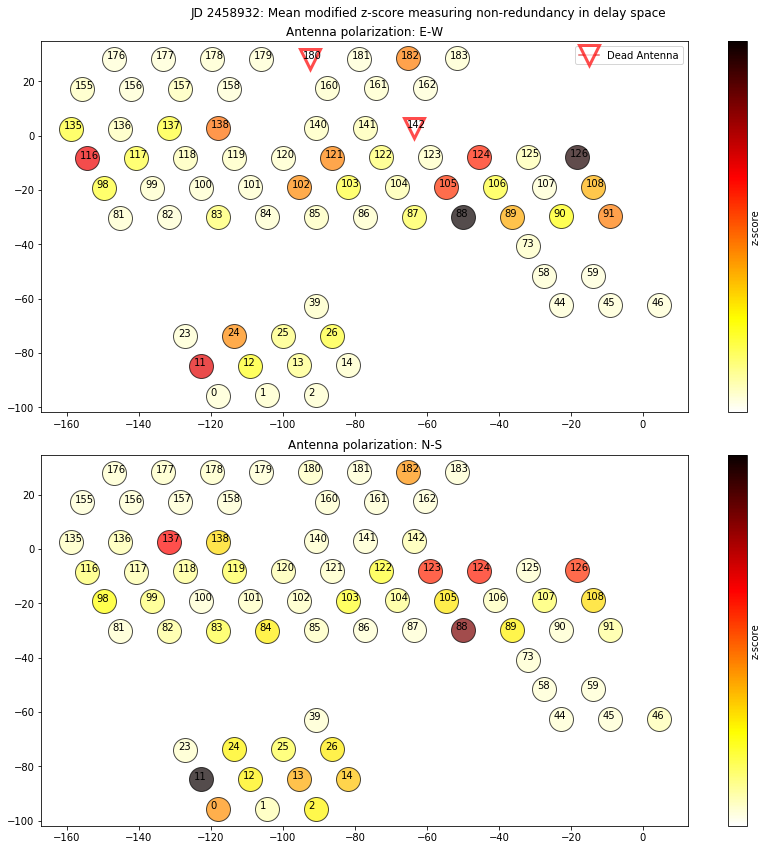

In [131]:
smPath932 = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458932/zen.2458932.59273.sum.uvh5'
dfPath932 = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458932/zen.2458932.59273.diff.uvh5'

#zscores932 = get_delayRedundancyMeasure(smPath932, dfPath932, pols=['xx','yy'], nThresh=25)
plotHeatBubbles_delayRedundancy(smPath932, dfPath932, pols=['xx','yy'], zscores=zscores932)

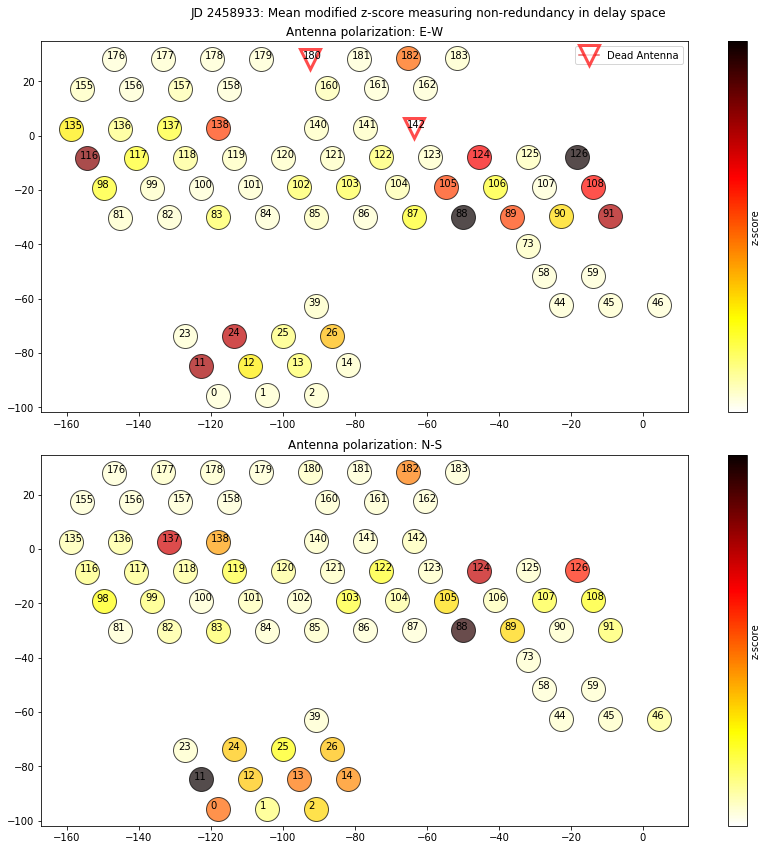

In [132]:
smPath933 = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458933/zen.2458933.60225.sum.uvh5'
dfPath933 = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458933/zen.2458933.60225.diff.uvh5'

#zscores933 = get_delayRedundancyMeasure(smPath933, dfPath933, pols=['xx','yy'], nThresh=25)
plotHeatBubbles_delayRedundancy(smPath933, dfPath933, pols=['xx','yy'], zscores=zscores933, alpha=0.7)

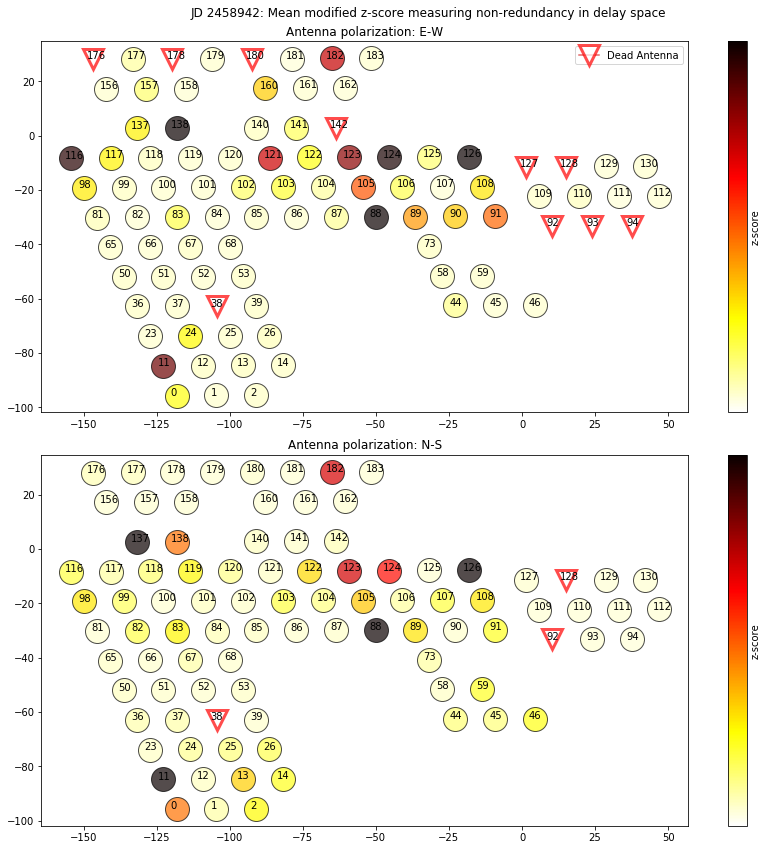

In [133]:
smPath942 = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458942/zen.2458942.54356.sum.uvh5'
dfPath942 = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458942/zen.2458942.54356.diff.uvh5'

#zscores942 = get_delayRedundancyMeasure(smPath942, dfPath942, pols=['xx','yy'], nThresh=25)
plotHeatBubbles_delayRedundancy(smPath942, dfPath942, pols=['xx','yy'], zscores=zscores942)

Total number of baseline groups is: 338
Calculating for polarization: xx
0 - 58 baselines


divide by zero encountered in log10
Casting complex values to real discards the imaginary part


antennas (141,142) have nan values
antennas (179,180) have nan values
antennas (180,181) have nan values
1 - 47 baselines
antennas (140,142) have nan values
antennas (178,180) have nan values
antennas (180,182) have nan values
2 - 47 baselines
antennas (142,123) have nan values
antennas (180,160) have nan values
3 - 42 baselines
antennas (122,142) have nan values
4 - 35 baselines
antennas (121,142) have nan values
antennas (158,180) have nan values
5 - 28 baselines
antennas (120,142) have nan values
antennas (157,180) have nan values
6 - 26 baselines
antennas (142,105) have nan values
7 - 23 baselines
antennas (104,142) have nan values
8 - 19 baselines
antennas (103,142) have nan values
39 - 23 baselines
antennas (142,106) have nan values
50 - 34 baselines
antennas (142,125) have nan values
antennas (180,162) have nan values
51 - 41 baselines
antennas (142,124) have nan values
antennas (180,161) have nan values
52 - 21 baselines
antennas (142,107) have nan values
68 - 37 baselines
ante

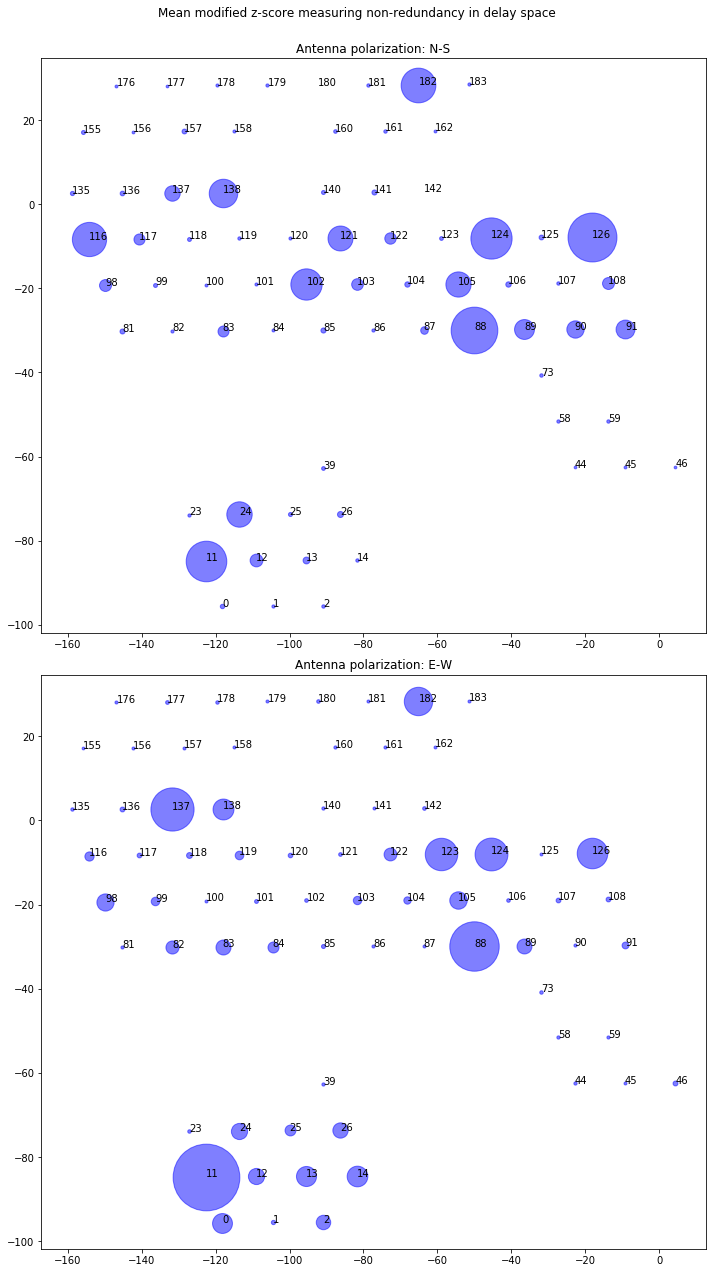

In [66]:
smPath932 = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458932/zen.2458932.59273.sum.uvh5'
dfPath932 = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458932/zen.2458932.59273.diff.uvh5'

zscores932 = get_delayRedundancyMeasure(smPath932, dfPath932, pols=['xx','yy'], nThresh=15)
plotBubbles_delayRedundancy(smPath932, dfPath932, pols=['xx','yy'], zscores=zscores932)

Total number of baseline groups is: 338
Calculating for polarization: xx
0 - 58 baselines


K1 value 8 is larger than the data of dimension 2; using the size of the data for the kernel size
divide by zero encountered in log10
Casting complex values to real discards the imaginary part


antennas (141,142) have nan values
antennas (179,180) have nan values
antennas (180,181) have nan values
1 - 47 baselines
antennas (140,142) have nan values
antennas (178,180) have nan values
antennas (180,182) have nan values
2 - 47 baselines
antennas (142,123) have nan values
antennas (180,160) have nan values
3 - 42 baselines
antennas (122,142) have nan values
4 - 35 baselines
antennas (121,142) have nan values
antennas (158,180) have nan values
5 - 28 baselines
antennas (120,142) have nan values
antennas (157,180) have nan values
6 - 26 baselines
antennas (142,105) have nan values
7 - 23 baselines
antennas (104,142) have nan values
8 - 19 baselines
antennas (103,142) have nan values
39 - 23 baselines
antennas (142,106) have nan values
50 - 34 baselines
antennas (142,125) have nan values
antennas (180,162) have nan values
51 - 41 baselines
antennas (142,124) have nan values
antennas (180,161) have nan values
52 - 21 baselines
antennas (142,107) have nan values
68 - 37 baselines
ante

All-NaN slice encountered


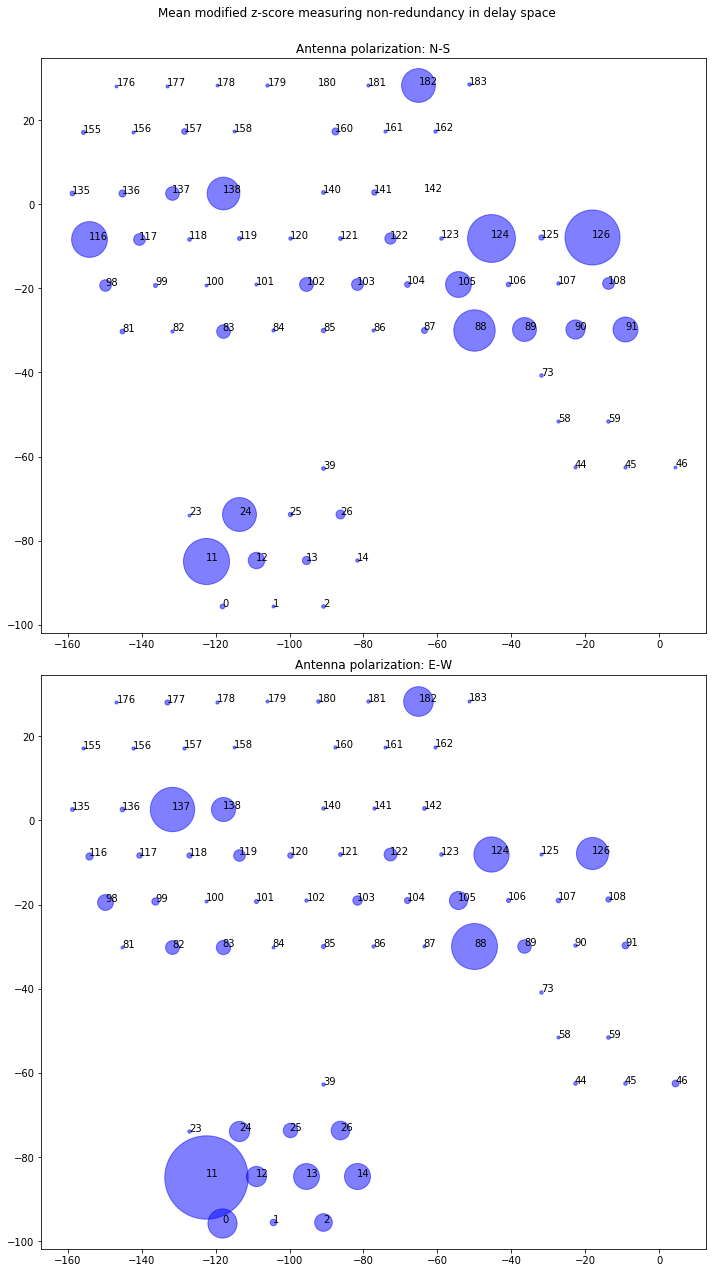

In [9]:
smPath933 = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458933/zen.2458933.60225.sum.uvh5'
dfPath933 = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458933/zen.2458933.60225.diff.uvh5'

zscores933 = get_delayRedundancyMeasure(smPath933, dfPath933, pols=['xx','yy'], nThresh=15)
plotBubbles_delayRedundancy(smPath933, dfPath933, pols=['xx','yy'], zscores=zscores933)

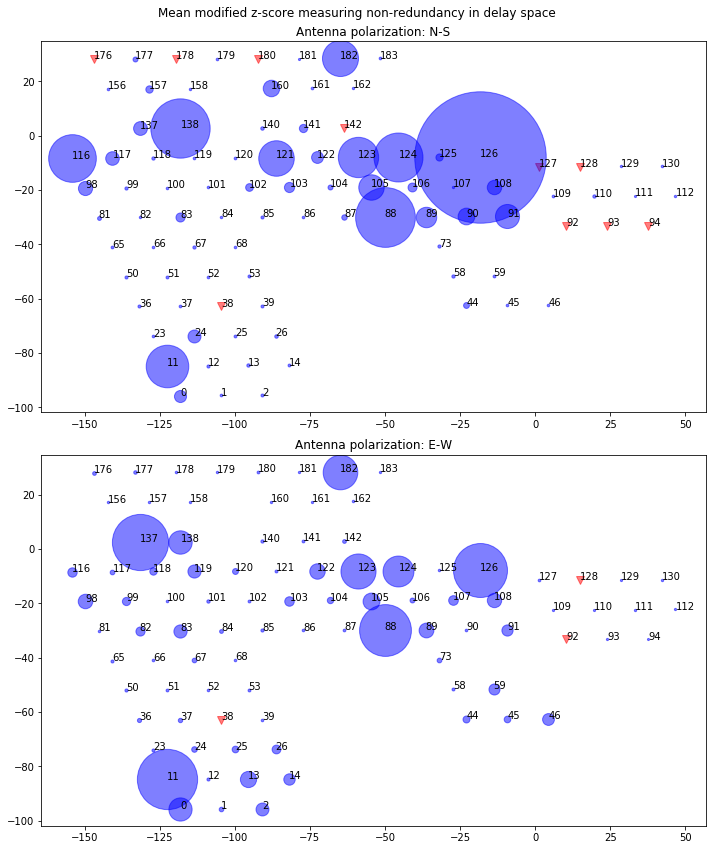

In [30]:
smPath942 = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458942/zen.2458942.54356.sum.uvh5'
dfPath942 = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458942/zen.2458942.54356.diff.uvh5'

zscores942 = get_delayRedundancyMeasure(smPath942, dfPath942, pols=['xx','yy'], nThresh=25)

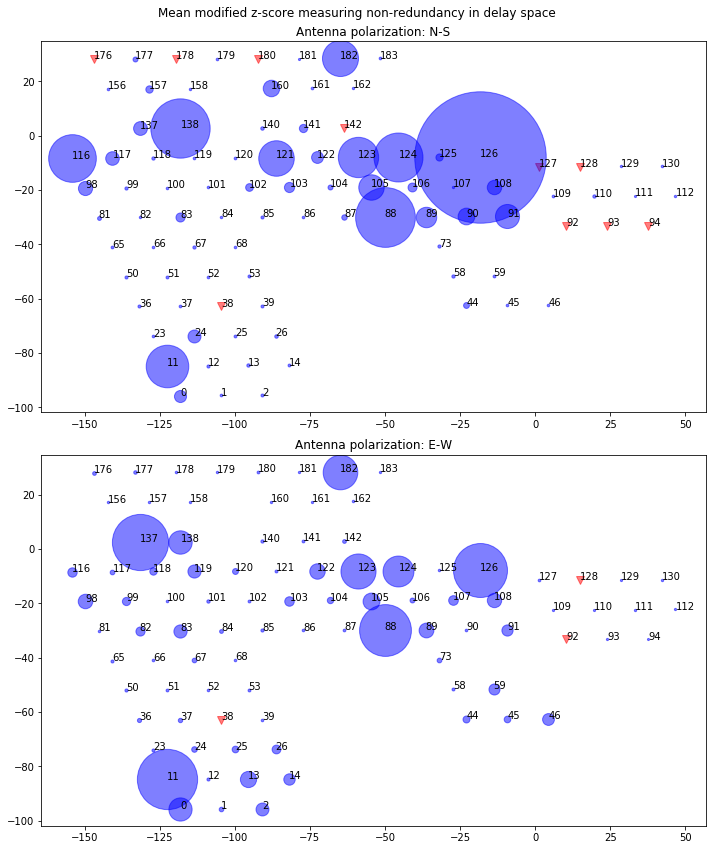

In [31]:
plotBubbles_delayRedundancy(smPath942, dfPath942, pols=['xx','yy'], zscores=zscores942)

Total number of baseline groups is: 497
Calculating for polarization: xx
0 - 72 baselines


divide by zero encountered in log10
Casting complex values to real discards the imaginary part
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


antennas (37,38) have nan values
antennas (38,39) have nan values
antennas (92,93) have nan values
antennas (93,94) have nan values
antennas (127,128) have nan values
antennas (128,129) have nan values
antennas (141,142) have nan values
antennas (176,177) have nan values
antennas (177,178) have nan values
antennas (178,179) have nan values
antennas (179,180) have nan values
antennas (180,181) have nan values
Calculating for polarization: yy
0 - 72 baselines
antennas (37,38) have nan values
antennas (38,39) have nan values
antennas (92,93) have nan values
antennas (127,128) have nan values
antennas (128,129) have nan values


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
Mean of empty slice


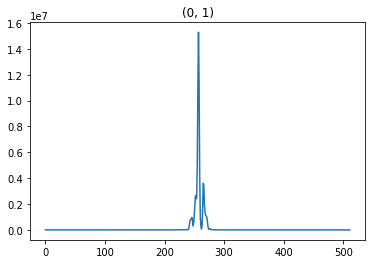

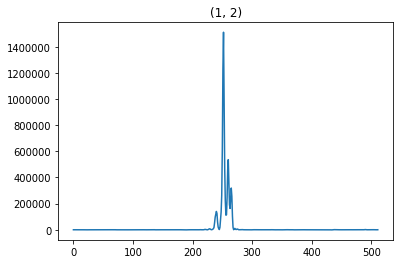

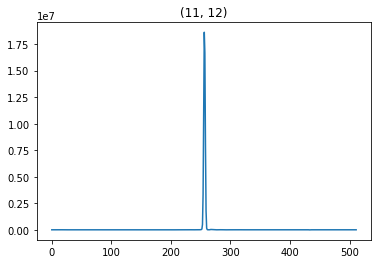

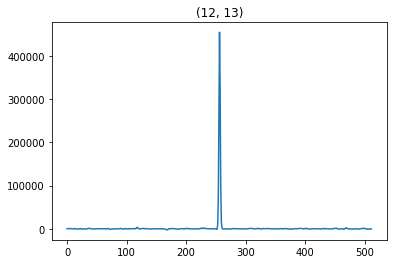

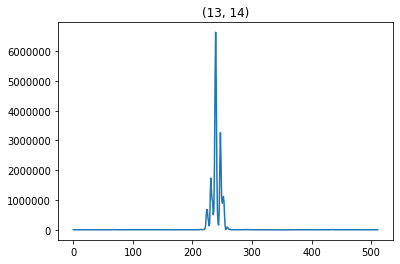

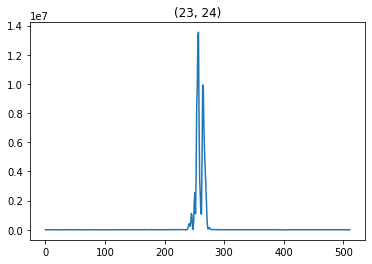

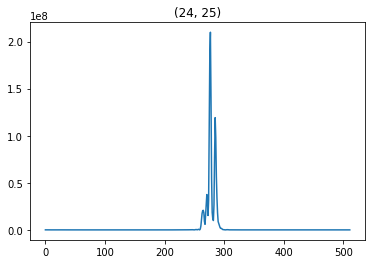

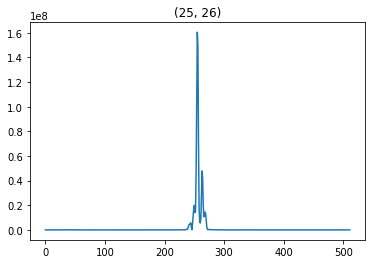

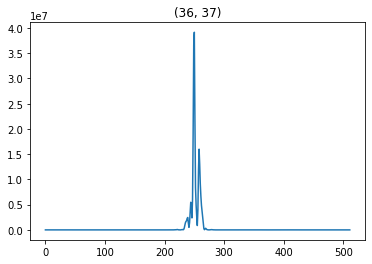

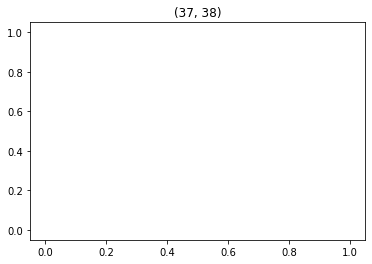

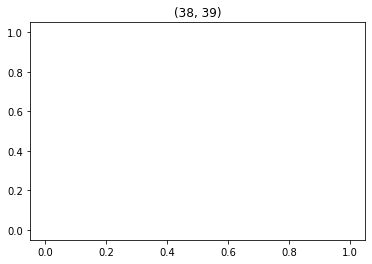

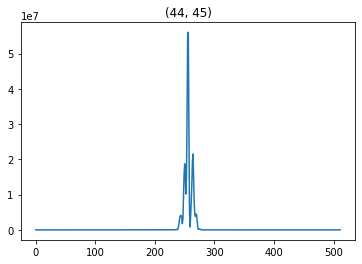

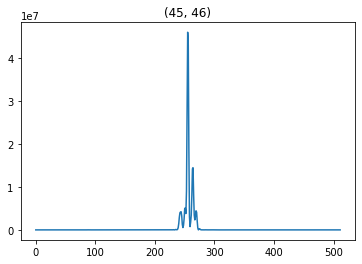

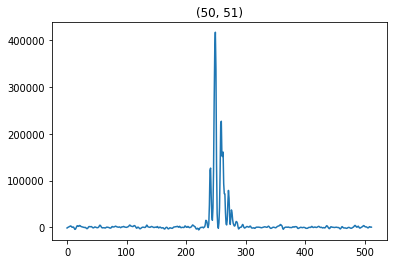

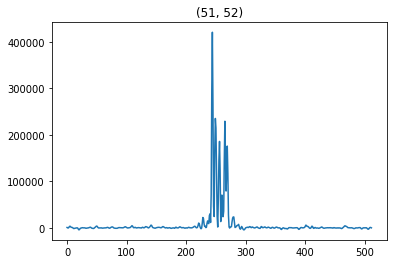

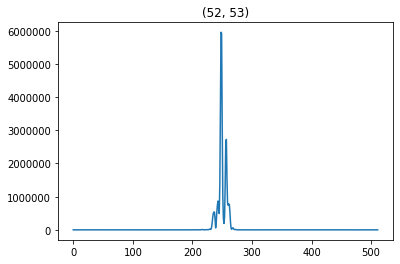

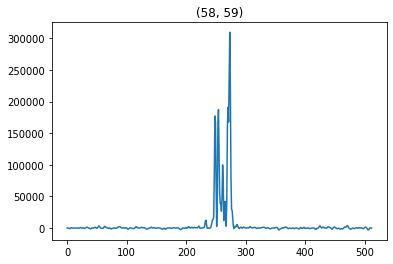

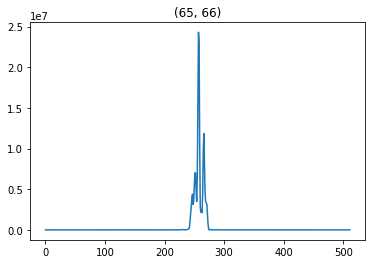

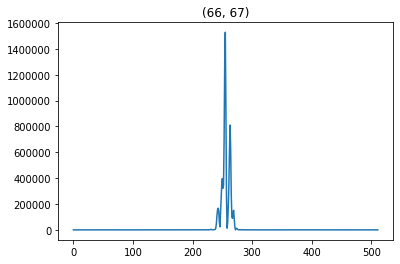

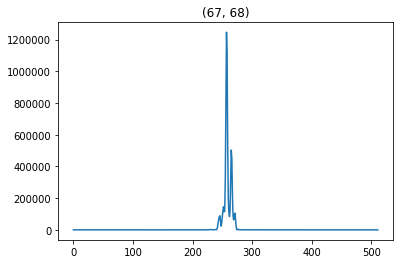

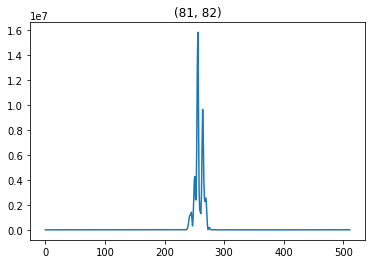

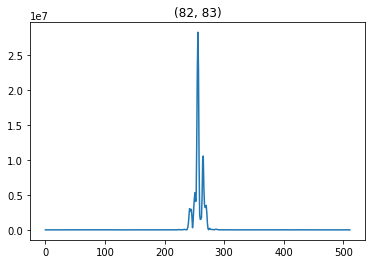

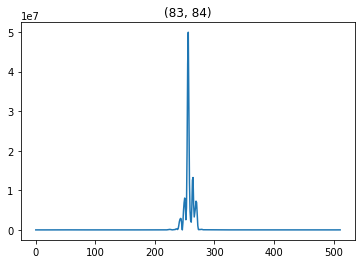

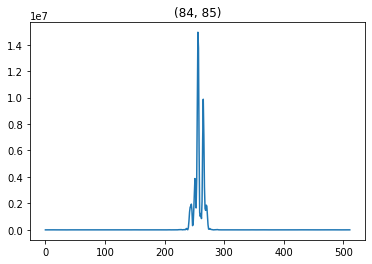

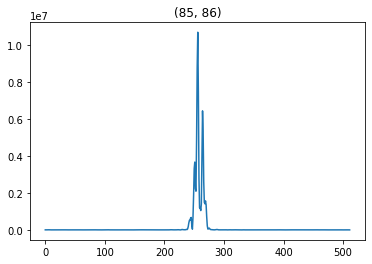

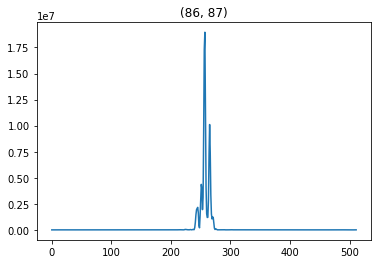

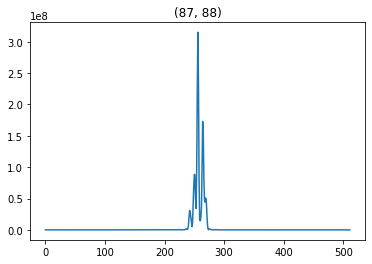

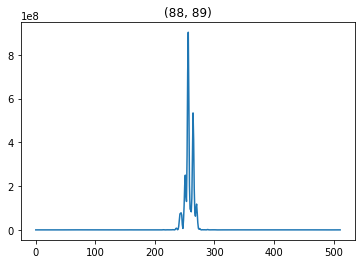

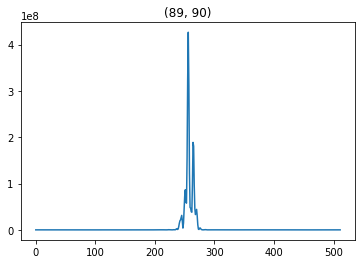

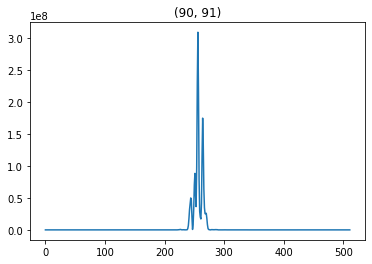

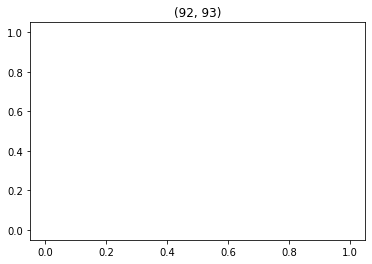

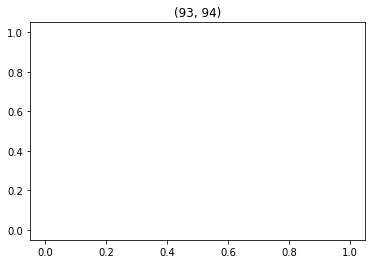

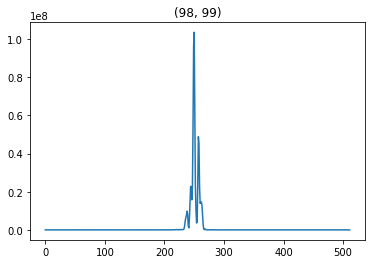

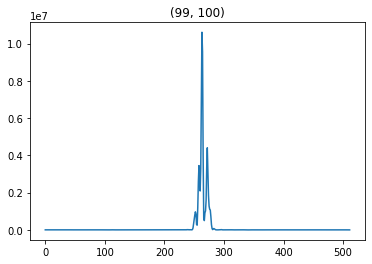

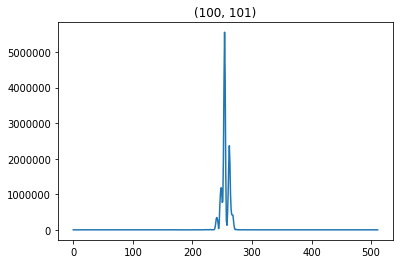

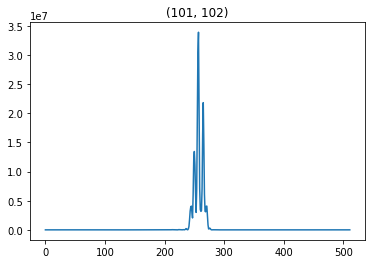

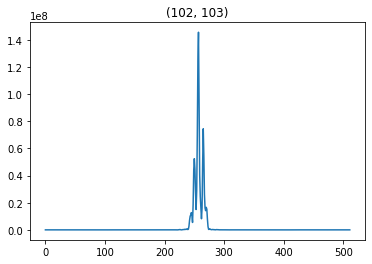

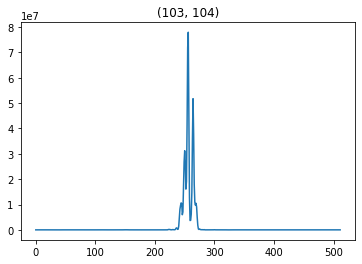

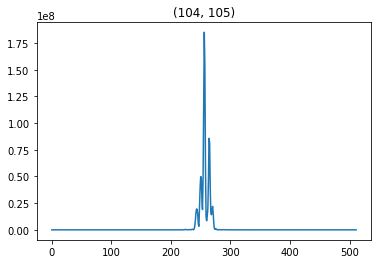

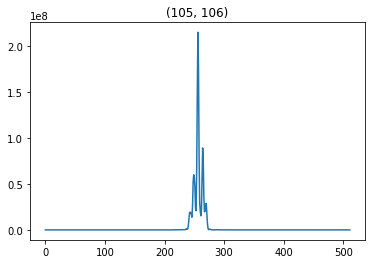

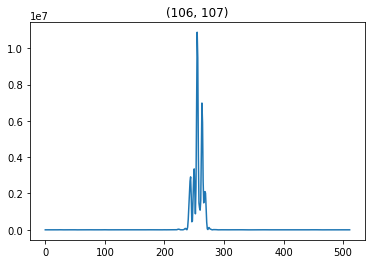

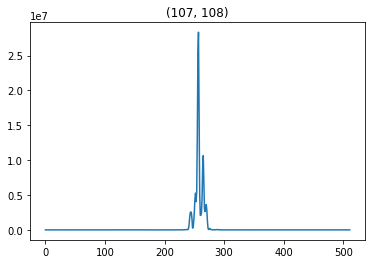

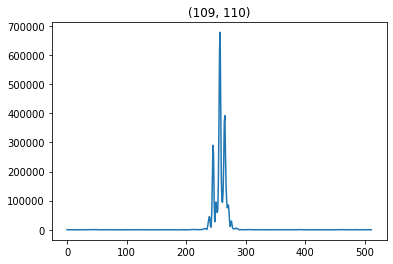

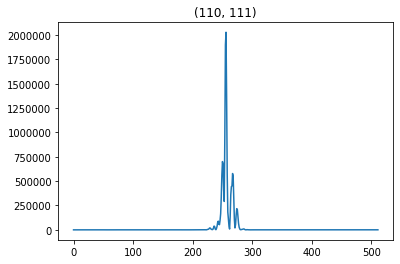

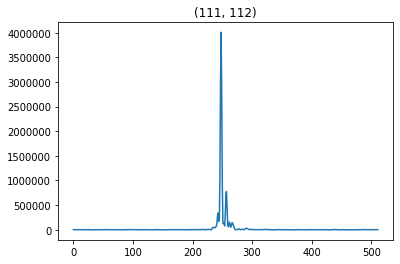

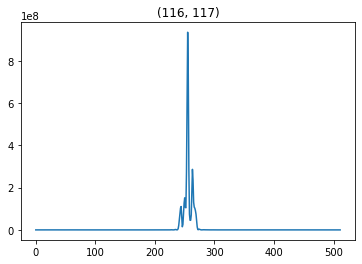

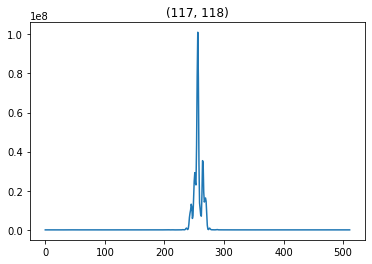

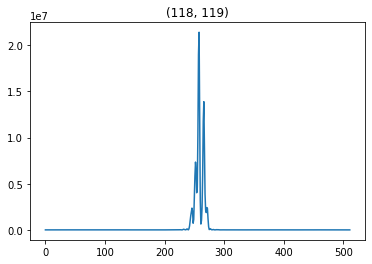

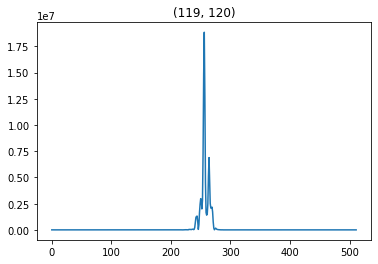

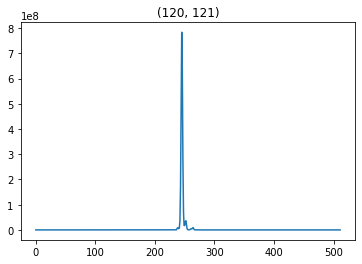

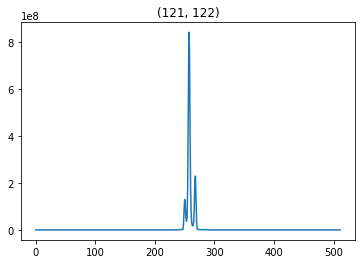

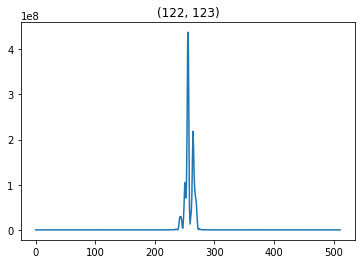

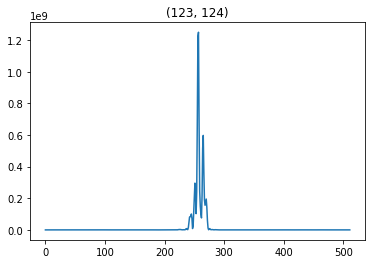

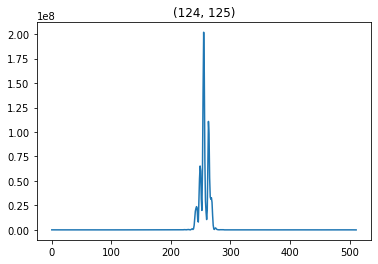

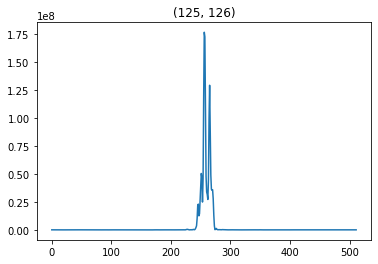

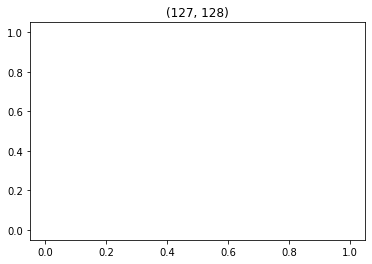

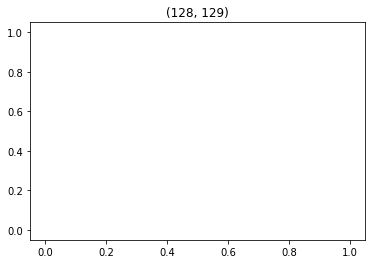

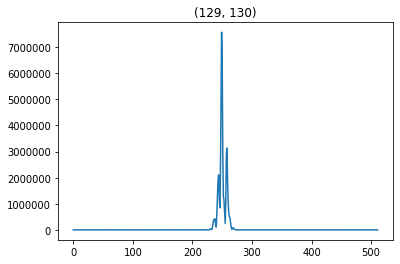

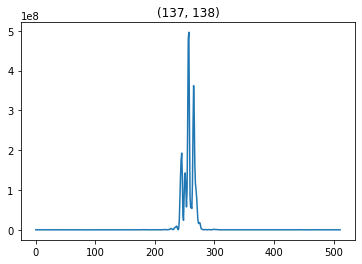

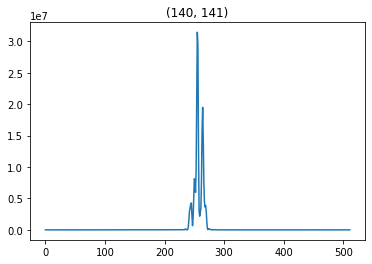

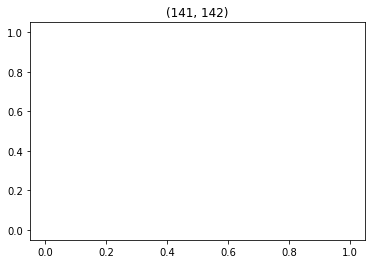

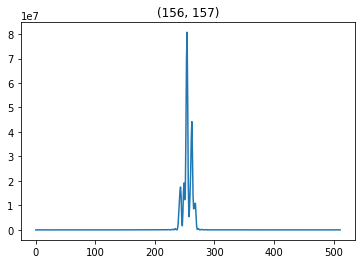

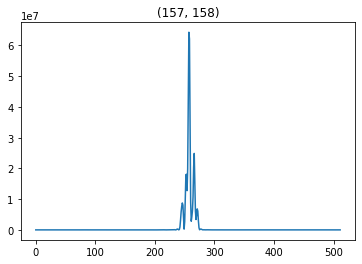

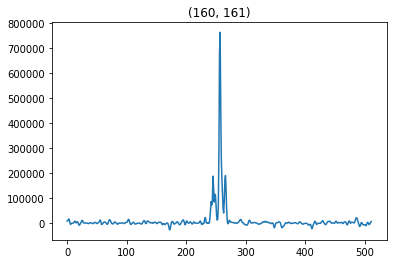

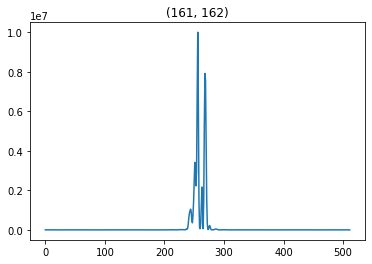

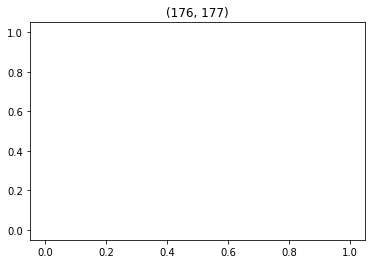

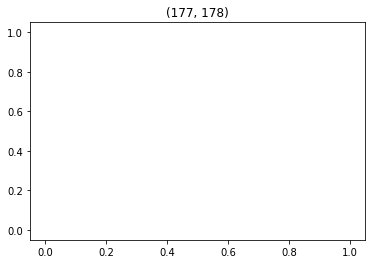

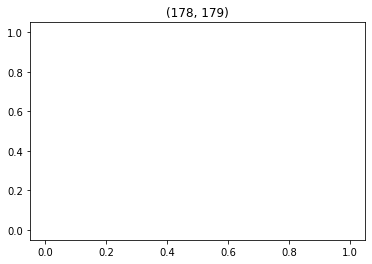

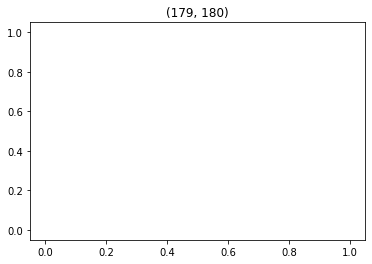

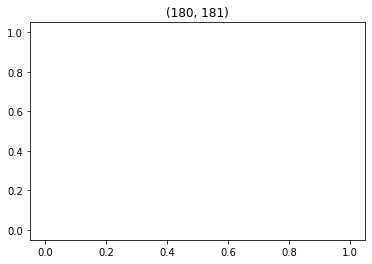

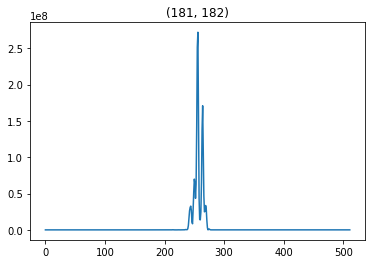

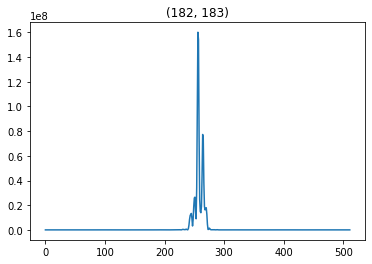

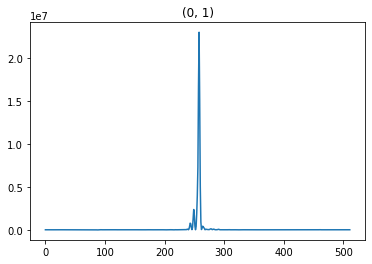

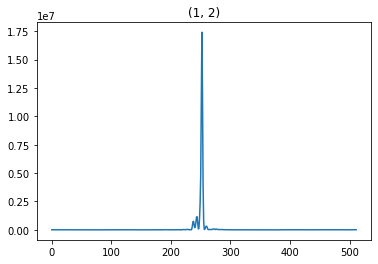

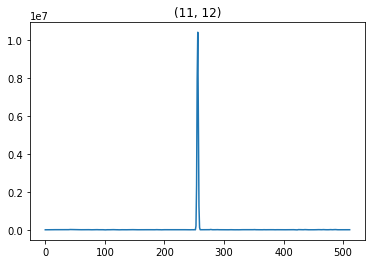

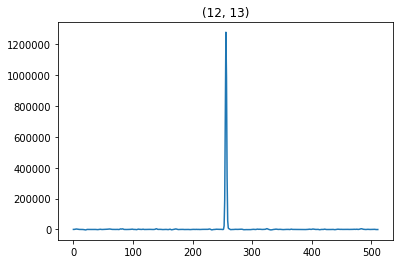

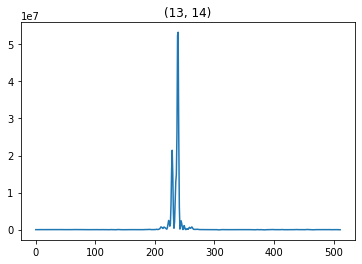

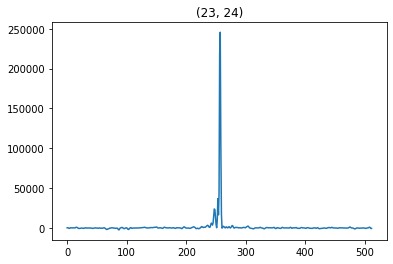

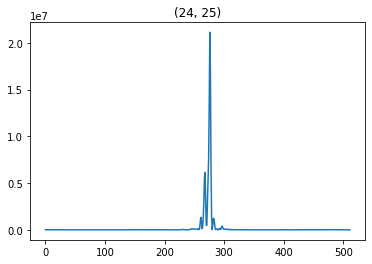

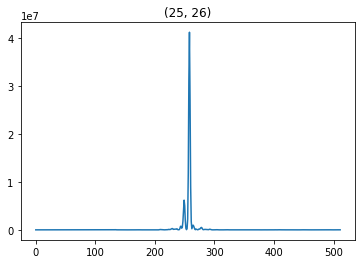

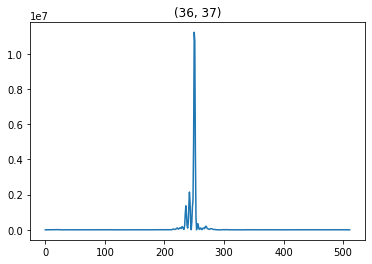

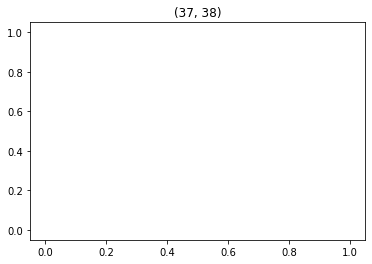

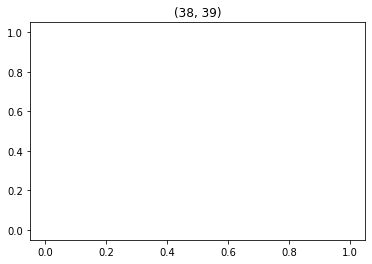

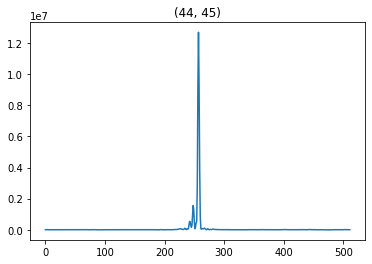

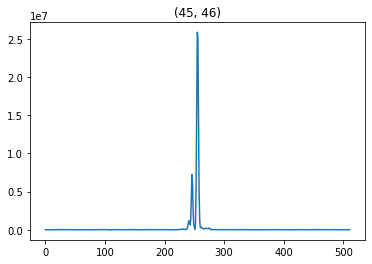

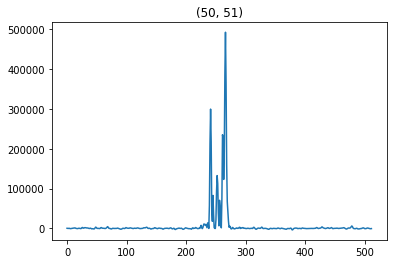

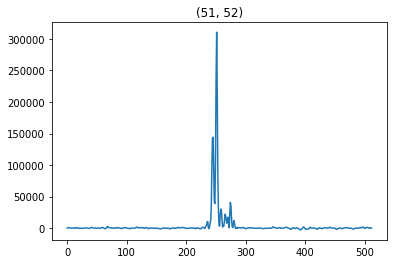

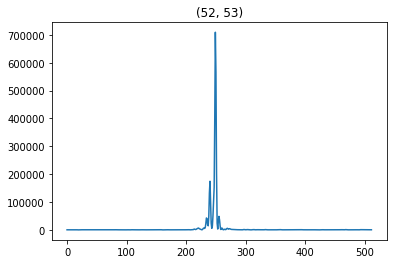

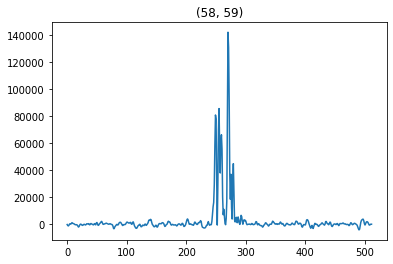

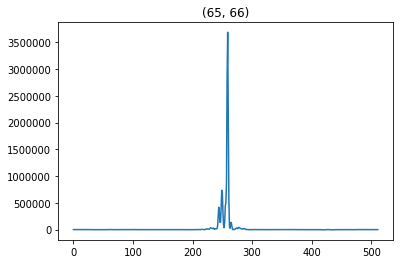

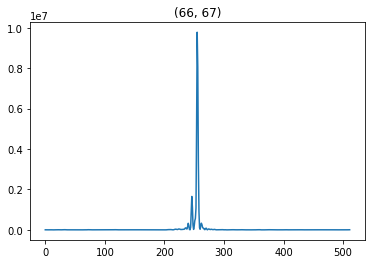

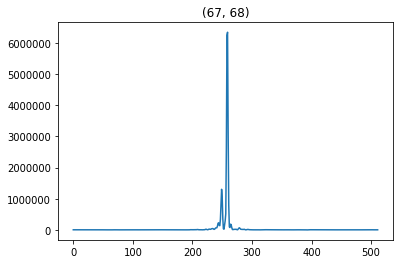

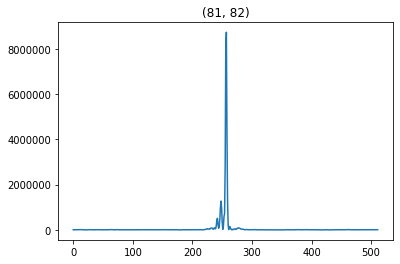

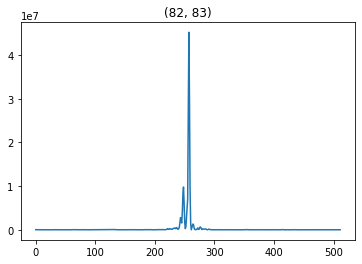

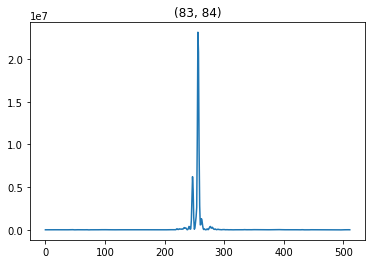

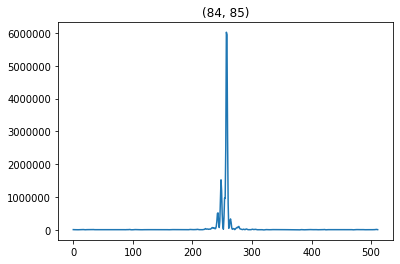

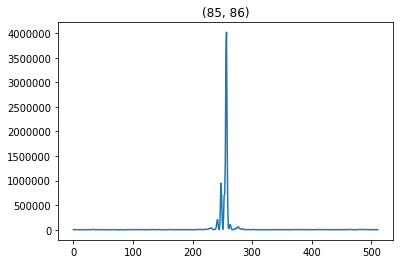

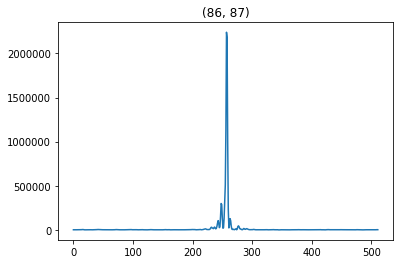

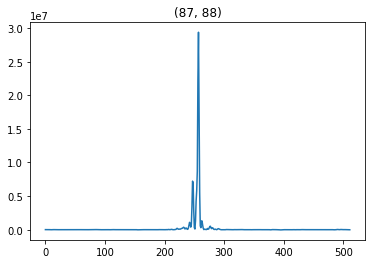

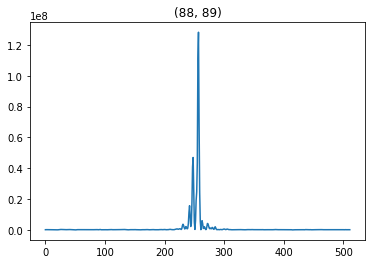

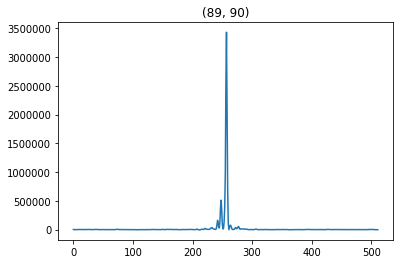

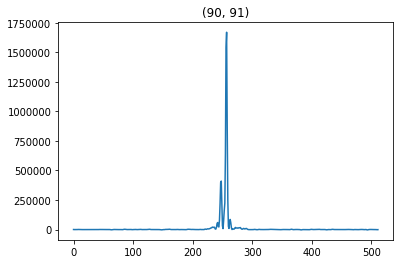

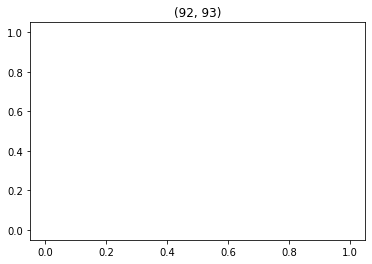

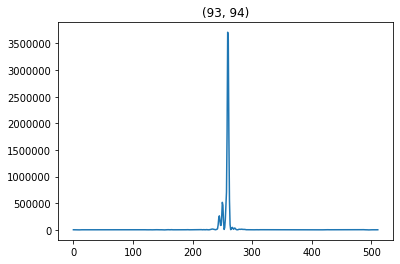

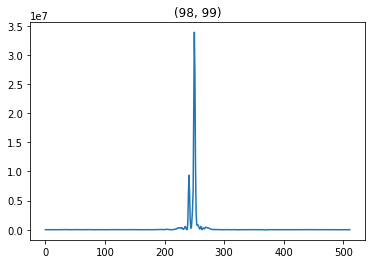

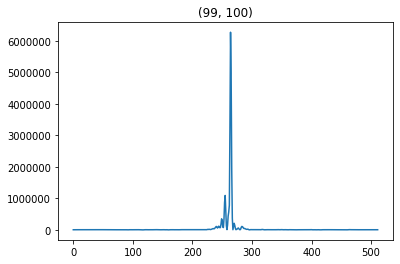

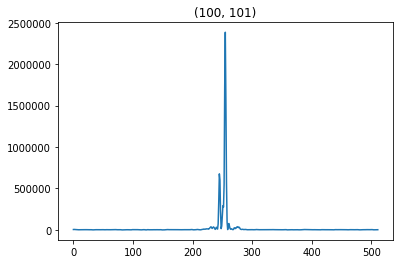

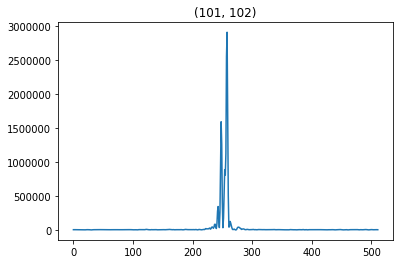

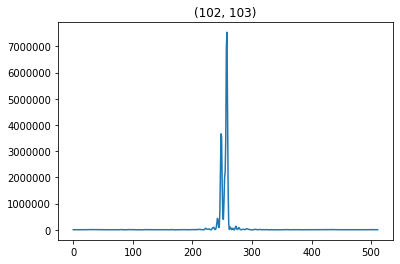

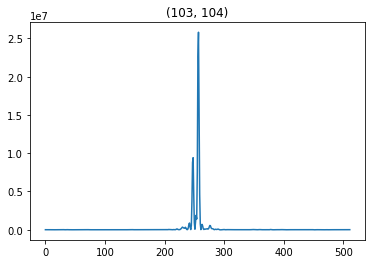

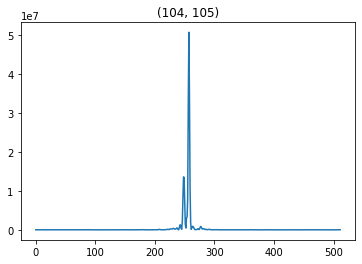

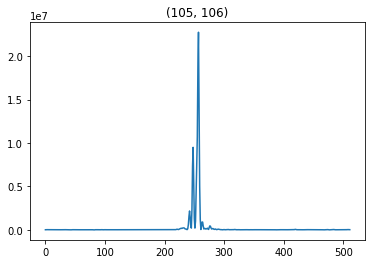

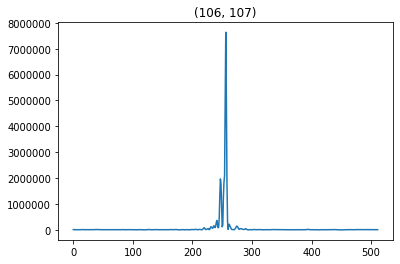

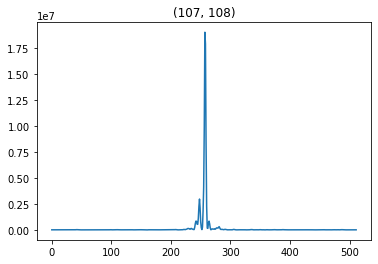

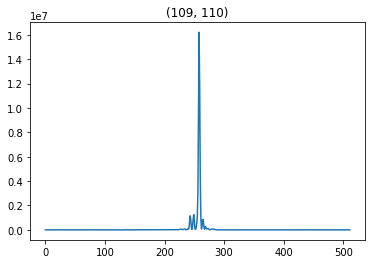

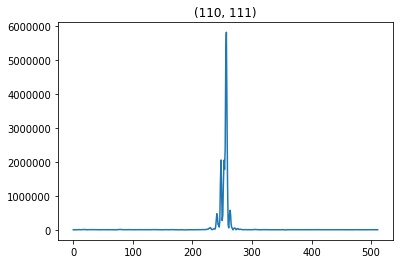

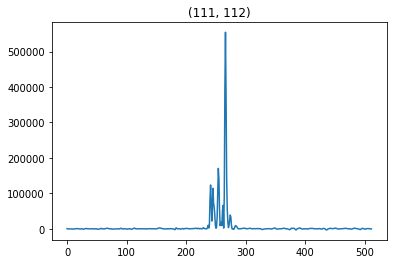

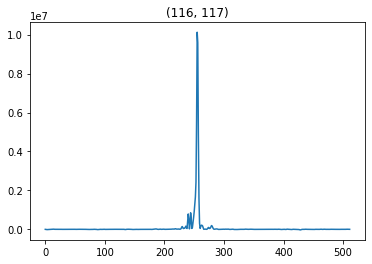

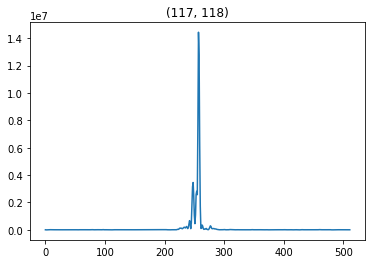

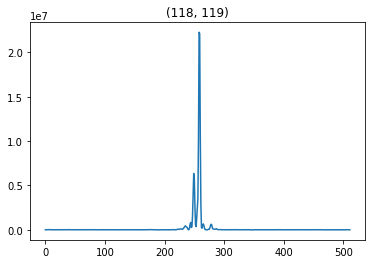

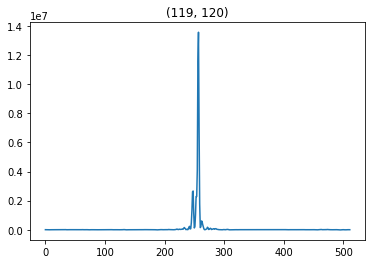

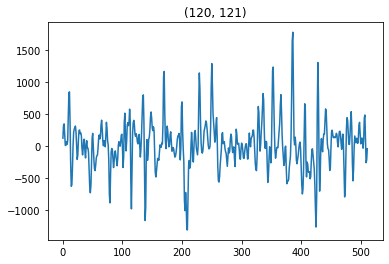

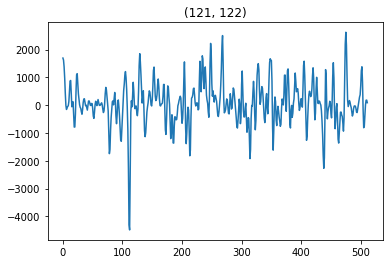

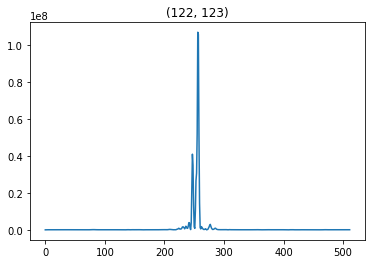

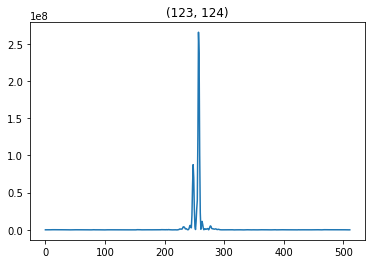

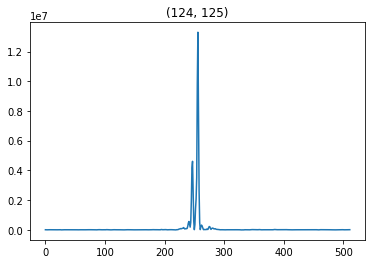

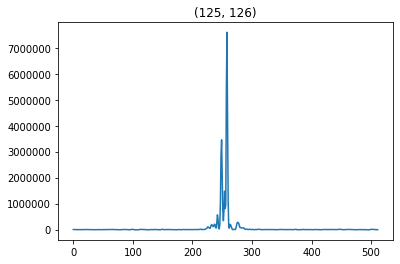

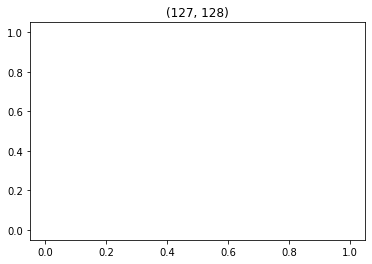

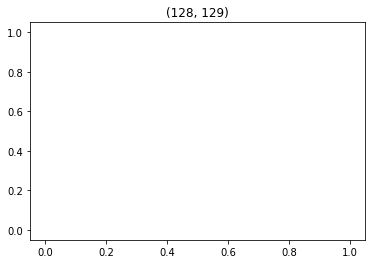

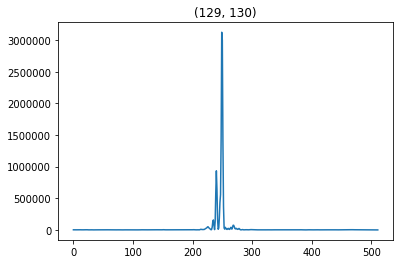

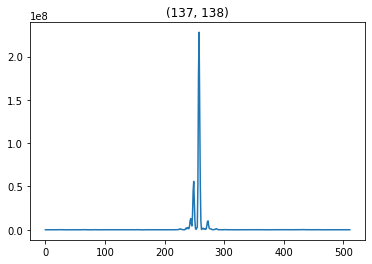

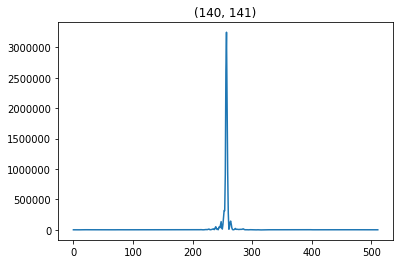

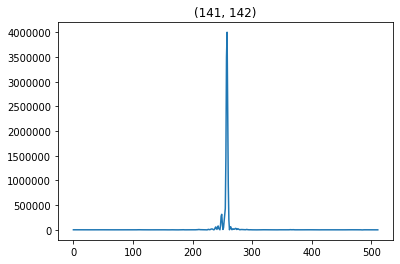

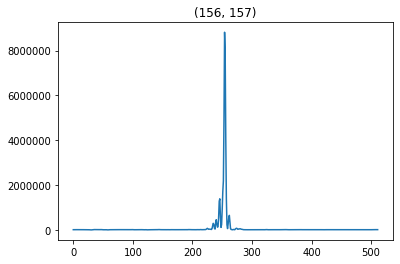

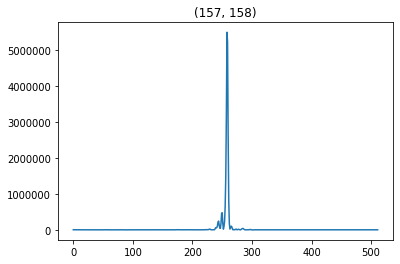

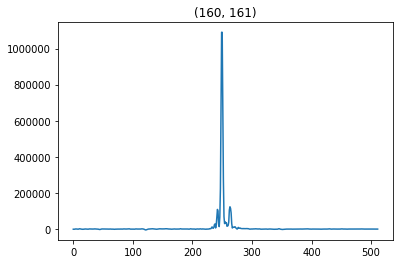

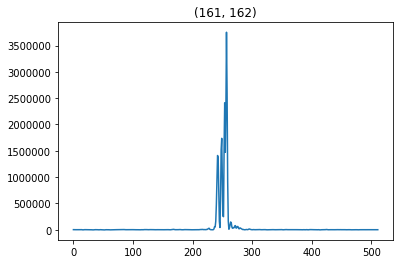

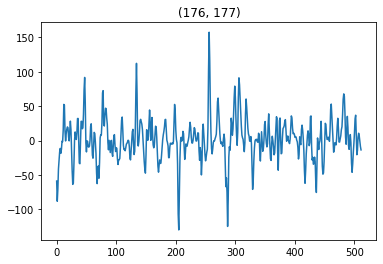

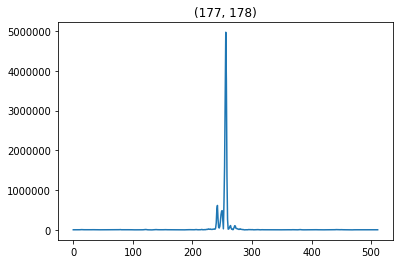

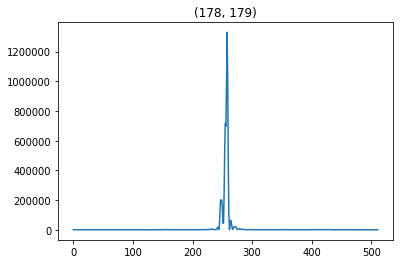

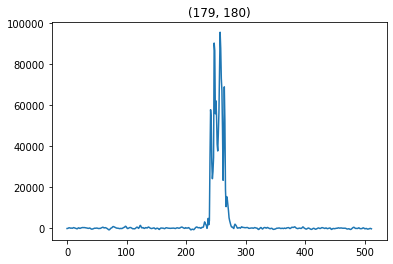

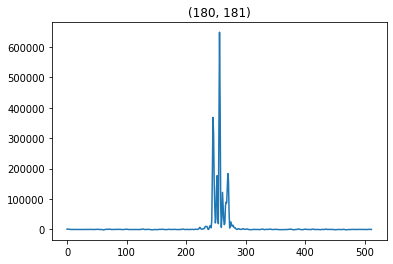

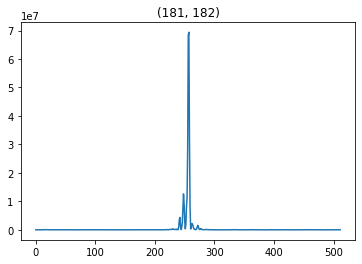

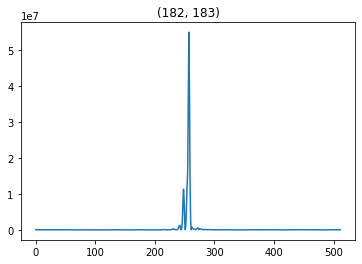

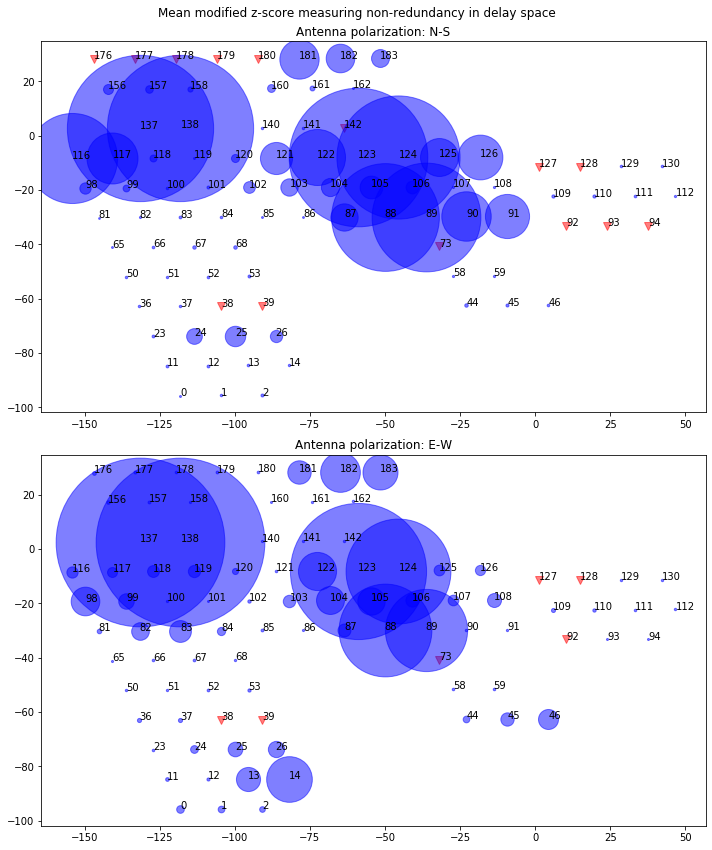

In [34]:
smPath942 = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458942/zen.2458942.54356.sum.uvh5'
dfPath942 = '/lustre/aoc/projects/hera/dstorer/H3C_data/2458942/zen.2458942.54356.diff.uvh5'

zscores942 = get_delayRedundancyMeasure(smPath942, dfPath942, pols=['xx','yy'], nThresh=71)
plotBubbles_delayRedundancy(smPath942, dfPath942, pols=['xx','yy'], zscores=zscores942)